In [1]:
libraries = c("arrow","tidyverse","readr","scales","purrr","ggpmisc","usmap","reshape2", "data.table", "arrow",
              "tidytext", "lubridate")
for(x in libraries) {library(x, character.only=TRUE, warn.conflicts=FALSE, quietly=TRUE)}

'%&%' = function(x,y)paste0(x,y)

theme_set(theme_bw())
version$version.string

── Attaching core tidyverse packages ──────────────────────── tidyverse 2.0.0 ──
✔ dplyr     1.1.2     ✔ readr     2.1.4
✔ forcats   1.0.0     ✔ stringr   1.5.0
✔ ggplot2   3.4.2     ✔ tibble    3.2.1
✔ lubridate 1.9.2     ✔ tidyr     1.3.0
✔ purrr     1.0.1     
── Conflicts ────────────────────────────────────────── tidyverse_conflicts() ──
✖ lubridate::duration() masks arrow::duration()
✖ dplyr::filter()       masks stats::filter()
✖ dplyr::lag()          masks stats::lag()
ℹ Use the conflicted package (<http://conflicted.r-lib.org/>) to force all conflicts to become errors

Attaching package: ‘ggpp’


The following object is masked from ‘package:ggplot2’:

    annotate


Registered S3 method overwritten by 'ggpmisc':
  method                  from   
  as.character.polynomial polynom



[1] "R version 4.2.2 (2022-10-31)"

# Data

In [2]:
schema <- arrow::schema(
  arrow::field("origin_date", arrow::string()),
  arrow::field("scenario_id", arrow::string()),
  arrow::field("location", arrow::string()),
  arrow::field("target", arrow::string()),
  arrow::field("horizon", double()),
  arrow::field("type", arrow::string()),
  arrow::field("type_id", double()),
  arrow::field("model_name", arrow::string()),
  arrow::field("value", double()),
)

In [3]:
##load the data
repo_data <- "../covid19-megaround_data/"
folder_path <- "megaround-processed/"

dc <- arrow::open_dataset(paste0(repo_data, folder_path), partitioning = "model_name", 
                          format = "parquet", schema = schema,
                          factory_options = list(
                            exclude_invalid_files = TRUE))


df_sample <- dplyr::filter(dc, type == "sample" & (target == "inc death" |  target == "inc hosp")) %>% 
  dplyr::collect()


##filter out longer time horizons
df_sample <- df_sample %>% filter(horizon<=104)

##regreate projection date
df_sample <- df_sample %>% mutate(origin_date = lubridate::as_date(origin_date))

##Create a season indicator
##First let's recreate the projection date
df_sample <- df_sample %>%
  mutate(proj_date = origin_date + horizon*7)

##Let's chop up on date. First let's make it based on 4 equa
##week periods
date_cuts <- c("2023-04-15","2024-04-15","2025-05-01")
date_cuts<-lubridate::as_date(date_cuts)
df_sample <- df_sample %>% 
  mutate(period=cut(proj_date, date_cuts, 
                    labels = c("season 2023-24",
                               "season 2024-25")))

In [4]:
prob_list <- c(0.95, 0.75, 0.25, 0.05)

In [5]:
unique(df_sample$model_name)

[1] "NCSU-COVSIM"          "MOBS_NEU-GLEAM_COVID" "JHU_IDD-CovidSP"     
[4] "NotreDame-FRED"       "UNCC-hierbin"         "USC-SIkJalpha"       
[7] "UTA-ImmunoSEIRS"      "UVA-EpiHiper"         "UVA-adaptive"

# Table 1: Peak size & timing at the national-level

### Hospitalizations peak timing at the national-level

In [6]:
df_sample_date <- df_sample %>% filter(location=="US") %>% 
group_by(scenario_id, target, model_name, period, type_id) %>%
slice(which.max(value)) %>% ungroup()

In [7]:
df_sample_date %>% filter(target=="inc hosp") %>%
mutate(scenario=recode(scenario_id, 
                       "A-2023-04-16" = "No booster \n Low immune escape", 
                       "B-2023-04-16" = "No booster \n High immune escape", 
                       "C-2023-04-16"="Booster for 65+ \n Low immune escape", 
                       "D-2023-04-16"="Booster for 65+ \n High immune escape", 
                       "E-2023-04-16"="Booster for all \n Low immune escape",
                       "F-2023-04-16"="Booster for all \n High immune escape")) %>%
filter(period=="season 2023-24") -> prob_hosp_2023_df

df_sample_date %>% filter(target=="inc hosp") %>%
mutate(scenario=recode(scenario_id, 
                       "A-2023-04-16" = "No booster \n Low immune escape", 
                       "B-2023-04-16" = "No booster \n High immune escape", 
                       "C-2023-04-16"="Booster for 65+ \n Low immune escape", 
                       "D-2023-04-16"="Booster for 65+ \n High immune escape", 
                       "E-2023-04-16"="Booster for all \n Low immune escape",
                       "F-2023-04-16"="Booster for all \n High immune escape")) %>%
filter(period=="season 2024-25"& proj_date <= as.Date("2025-04-19")) -> prob_hosp_2024_df

In [8]:
prob_hosp_2023_df %>%
  group_by(scenario, model_name) %>%
  summarize(mx_median = median(proj_date),
            mx_q975=as.Date(quantile(unclass(proj_date),prob_list[1]), origin=("1970-01-01")),
            mx_q75=as.Date(quantile(unclass(proj_date),prob_list[2]), origin=("1970-01-01")),
            mx_q25=as.Date(quantile(unclass(proj_date),prob_list[3]), origin=("1970-01-01")),
            mx_q025=as.Date(quantile(unclass(proj_date),prob_list[4]), origin=("1970-01-01")))%>%
  ungroup() -> prob_hosp_2023_boxdf

prob_hosp_2024_df %>%
  group_by(scenario, model_name) %>%
  summarize(mx_median = median(proj_date),
            mx_q975=as.Date(quantile(unclass(proj_date),prob_list[1]), origin=("1970-01-01")),
            mx_q75=as.Date(quantile(unclass(proj_date),prob_list[2]), origin=("1970-01-01")),
            mx_q25=as.Date(quantile(unclass(proj_date),prob_list[3]), origin=("1970-01-01")),
            mx_q025=as.Date(quantile(unclass(proj_date),prob_list[4]), origin=("1970-01-01")))%>%
  ungroup() -> prob_hosp_2024_boxdf

prob_hosp_2023_df %>%
  group_by(scenario) %>%
  summarize(mx_median = median(proj_date),
            mx_q975=as.Date(quantile(unclass(proj_date),prob_list[1]), origin=("1970-01-01")),
            mx_q75=as.Date(quantile(unclass(proj_date),prob_list[2]), origin=("1970-01-01")),
            mx_q25=as.Date(quantile(unclass(proj_date),prob_list[3]), origin=("1970-01-01")),
            mx_q025=as.Date(quantile(unclass(proj_date),prob_list[4]), origin=("1970-01-01")))%>%
  ungroup() %>% mutate(model_name=c("Ensemble")) -> prob_hosp_2023_boxdf_ensemble

prob_hosp_2024_df %>%
  group_by(scenario) %>%
  summarize(mx_median = median(proj_date),
            mx_q975=as.Date(quantile(unclass(proj_date),prob_list[1]), origin=("1970-01-01")),
            mx_q75=as.Date(quantile(unclass(proj_date),prob_list[2]), origin=("1970-01-01")),
            mx_q25=as.Date(quantile(unclass(proj_date),prob_list[3]), origin=("1970-01-01")),
            mx_q025=as.Date(quantile(unclass(proj_date),prob_list[4]), origin=("1970-01-01")))%>%
  ungroup() %>% mutate(model_name=c("Ensemble")) -> prob_hosp_2024_boxdf_ensemble


rbind(prob_hosp_2023_boxdf, prob_hosp_2023_boxdf_ensemble) %>%
arrange(scenario, factor(model_name, 
                         levels=c("UVA-adaptive", "UTA-ImmunoSEIRS", "USC-SIkJalpha", "UNCC-hierbin", 
                                  "MOBS_NEU-GLEAM_COVID", "JHU_IDD_CovidSP", "Ensemble"))) -> prob_hosp_2023_boxdf

rbind(prob_hosp_2024_boxdf, prob_hosp_2024_boxdf_ensemble) %>%
arrange(scenario, factor(model_name, 
                         levels=c("UVA-adaptive", "UTA-ImmunoSEIRS", "USC-SIkJalpha", "UNCC-hierbin", 
                                  "MOBS_NEU-GLEAM_COVID", "JHU_IDD_CovidSP", "Ensemble"))) -> prob_hosp_2024_boxdf

`summarise()` has grouped output by 'scenario'. You can override using the
`.groups` argument.
`summarise()` has grouped output by 'scenario'. You can override using the
`.groups` argument.


In [9]:
prob_hosp_2023_boxdf$scenario <- factor(prob_hosp_2023_boxdf$scenario, 
levels=c("No booster \n Low immune escape", "No booster \n High immune escape",
         "Booster for 65+ \n Low immune escape", "Booster for 65+ \n High immune escape",
         "Booster for all \n Low immune escape", "Booster for all \n High immune escape"))

prob_hosp_2024_boxdf$scenario <- factor(prob_hosp_2024_boxdf$scenario, 
levels=c("No booster \n Low immune escape", "No booster \n High immune escape",
         "Booster for 65+ \n Low immune escape", "Booster for 65+ \n High immune escape",
         "Booster for all \n Low immune escape", "Booster for all \n High immune escape"))

In [10]:
## table
rbind(prob_hosp_2023_boxdf %>% mutate(season=c("2023-2024 season")), 
      prob_hosp_2024_boxdf %>% mutate(season=c("2024-2025 season"))) %>%
filter(model_name==c("Ensemble")) -> peak_timing_ensemble

peak_timing_ensemble

scenario,model_name,mx_median,mx_q975,mx_q75,mx_q25,mx_q025,season
<fct>,<chr>,<date>,<date>,<date>,<date>,<date>,<chr>
Booster for 65+ High immune escape,Ensemble,2023-12-10,2024-02-07,2024-01-14,2023-11-19,2023-10-15,2023-2024 season
Booster for 65+ Low immune escape,Ensemble,2023-12-10,2024-02-18,2024-01-21,2023-11-12,2023-08-13,2023-2024 season
Booster for all High immune escape,Ensemble,2023-12-10,2024-02-18,2024-01-21,2023-11-05,2023-10-08,2023-2024 season
Booster for all Low immune escape,Ensemble,2023-12-03,2024-03-03,2024-01-21,2023-11-05,2023-04-30,2023-2024 season
No booster High immune escape,Ensemble,2023-12-10,2024-04-14,2024-01-14,2023-11-20,2023-10-15,2023-2024 season
No booster Low immune escape,Ensemble,2023-12-13,2024-04-14,2024-01-21,2023-11-19,2023-08-13,2023-2024 season
Booster for 65+ High immune escape,Ensemble,2024-12-15,2025-02-23,2025-01-05,2024-11-17,2024-10-13,2024-2025 season
Booster for 65+ Low immune escape,Ensemble,2024-12-22,2025-03-09,2025-01-24,2024-11-24,2024-10-27,2024-2025 season
Booster for all High immune escape,Ensemble,2024-12-08,2025-02-19,2025-01-05,2024-11-03,2024-06-09,2024-2025 season


In [11]:
peak_timing_ensemble %>% dplyr::select(scenario, season, mx_median, mx_q025, mx_q975) %>%
filter(season=="2023-2024 season")

scenario,season,mx_median,mx_q025,mx_q975
<fct>,<chr>,<date>,<date>,<date>
Booster for 65+ High immune escape,2023-2024 season,2023-12-10,2023-10-15,2024-02-07
Booster for 65+ Low immune escape,2023-2024 season,2023-12-10,2023-08-13,2024-02-18
Booster for all High immune escape,2023-2024 season,2023-12-10,2023-10-08,2024-02-18
Booster for all Low immune escape,2023-2024 season,2023-12-03,2023-04-30,2024-03-03
No booster High immune escape,2023-2024 season,2023-12-10,2023-10-15,2024-04-14
No booster Low immune escape,2023-2024 season,2023-12-13,2023-08-13,2024-04-14


In [12]:
peak_timing_ensemble %>% dplyr::select(scenario, season, mx_median, mx_q025, mx_q975) %>%
filter(season=="2024-2025 season")

scenario,season,mx_median,mx_q025,mx_q975
<fct>,<chr>,<date>,<date>,<date>
Booster for 65+ High immune escape,2024-2025 season,2024-12-15,2024-10-13,2025-02-23
Booster for 65+ Low immune escape,2024-2025 season,2024-12-22,2024-10-27,2025-03-09
Booster for all High immune escape,2024-2025 season,2024-12-08,2024-06-09,2025-02-19
Booster for all Low immune escape,2024-2025 season,2024-12-15,2024-06-12,2025-03-09
No booster High immune escape,2024-2025 season,2024-12-15,2024-10-13,2025-04-13
No booster Low immune escape,2024-2025 season,2024-12-29,2024-10-27,2025-04-13


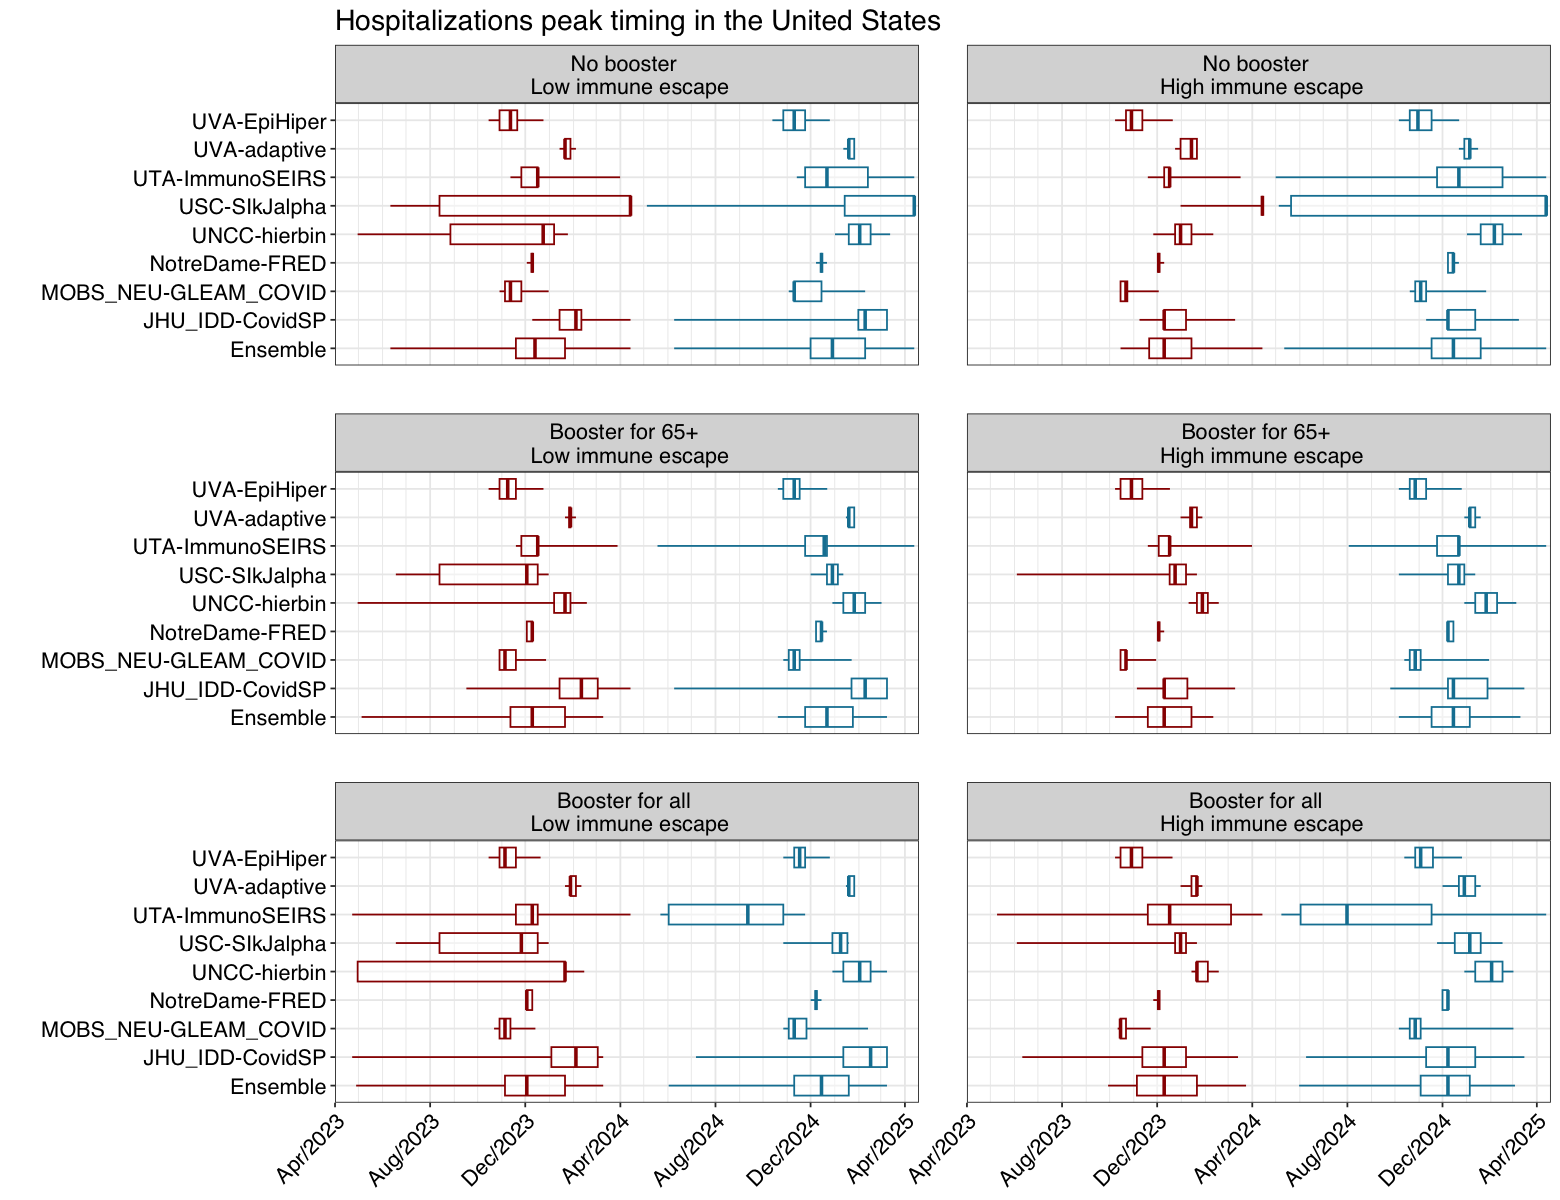

In [15]:
## figure by model
theme_set(theme_bw())
options(repr.plot.width=13,repr.plot.height=10)

prob_hosp_2023_boxdf %>%
ggplot(aes(x=model_name))+
facet_wrap(~scenario, nrow = 3)+
geom_boxplot(aes(ymin=mx_q025, lower=mx_q25, middle=mx_median, upper=mx_q75, ymax=mx_q975),
             stat="identity", color="#990000", width=0.7, alpha=0.5) + 
geom_boxplot(data=prob_hosp_2024_boxdf, 
             aes(ymin=mx_q025, lower=mx_q25, middle=mx_median, upper=mx_q75, ymax=mx_q975),
             stat="identity", color="#1380A1", width=0.7, alpha=0.5) + 
coord_flip()+
scale_y_date(date_labels = "%b/%Y", breaks = "4 months", date_minor_breaks = "1 month",
             limits=c(as.Date("2023-04-01"), as.Date("2025-04-19")), expand = c(0, 0)) +
theme(legend.position="none", 
      text = element_text(size=15, family="sans",color="black"),
      axis.text = element_text(size=13, family="sans",color="black"),
      plot.title = element_text(size=17, family="sans",color="black"),
      strip.text = element_text(size = 13, family="sans",color="black"),
      axis.text.x = element_text(angle=45, hjust=1),
      panel.spacing = unit(2, "lines")) +
labs(x="", title="Hospitalizations peak timing in the United States") -> peak_prob_hosp

peak_prob_hosp

ggsave("../covid19-scenario-modeling-hub-R17-paper/Figures/Figure_peak.tiff", 
       peak_prob_hosp, width=13, height=10)

# Peak timing by state

In [16]:
df_sample_date2 <- df_sample %>% group_by(scenario_id, target, model_name, period, type_id, location) %>%
slice(which.max(value)) %>% ungroup()

In [17]:
read.csv("../covid19-scenario-hub_analysis/data-locations/locations.csv") %>% 
dplyr::select(abbreviation, location, population) %>%
mutate(location=as.numeric(location)) -> df_loc

merge(df_sample_date2 %>% mutate(location=as.numeric(location)), 
      df_loc, by=c("location"), all.x=TRUE) %>% 
  filter(!(abbreviation%in%c("AS", "GU", "MP", "PR", "UM", "VI", "US"))) %>% 
dplyr::select(-location) -> df_sample_date2

Warning message:
“There was 1 warning in `mutate()`.
ℹ In argument: `location = as.numeric(location)`.
Caused by warning:
! NAs introduced by coercion”
Warning message:
“There was 1 warning in `mutate()`.
ℹ In argument: `location = as.numeric(location)`.
Caused by warning:
! NAs introduced by coercion”


In [18]:
df_sample_date2 %>% filter(target=="inc hosp") %>%
mutate(scenario=recode(scenario_id, 
                       "A-2023-04-16" = "No booster \n Low immune escape", 
                       "B-2023-04-16" = "No booster \n High immune escape", 
                       "C-2023-04-16"="Booster for 65+ \n Low immune escape", 
                       "D-2023-04-16"="Booster for 65+ \n High immune escape", 
                       "E-2023-04-16"="Booster for all \n Low immune escape",
                       "F-2023-04-16"="Booster for all \n High immune escape")) %>%
filter(period=="season 2023-24") -> prob_hosp_2023_df2

df_sample_date2 %>% filter(target=="inc hosp") %>%
mutate(scenario=recode(scenario_id, 
                       "A-2023-04-16" = "No booster \n Low immune escape", 
                       "B-2023-04-16" = "No booster \n High immune escape", 
                       "C-2023-04-16"="Booster for 65+ \n Low immune escape", 
                       "D-2023-04-16"="Booster for 65+ \n High immune escape", 
                       "E-2023-04-16"="Booster for all \n Low immune escape",
                       "F-2023-04-16"="Booster for all \n High immune escape")) %>%
filter(period=="season 2024-25"& proj_date <= as.Date("2025-04-19")) -> prob_hosp_2024_df2

In [19]:
prob_hosp_2023_df2 %>%
  group_by(scenario, abbreviation) %>%
  summarize(mx_median = median(proj_date),
            mx_q975=as.Date(quantile(unclass(proj_date),prob_list[1]), origin=("1970-01-01")),
            mx_q75=as.Date(quantile(unclass(proj_date),prob_list[2]), origin=("1970-01-01")),
            mx_q25=as.Date(quantile(unclass(proj_date),prob_list[3]), origin=("1970-01-01")),
            mx_q025=as.Date(quantile(unclass(proj_date),prob_list[4]), origin=("1970-01-01")))%>%
  ungroup() %>% mutate(model_name=c("Ensemble")) -> prob_hosp_2023_boxdf_ensemble

prob_hosp_2024_df2 %>%
  group_by(scenario, abbreviation) %>%
  summarize(mx_median = median(proj_date),
            mx_q975=as.Date(quantile(unclass(proj_date),prob_list[1]), origin=("1970-01-01")),
            mx_q75=as.Date(quantile(unclass(proj_date),prob_list[2]), origin=("1970-01-01")),
            mx_q25=as.Date(quantile(unclass(proj_date),prob_list[3]), origin=("1970-01-01")),
            mx_q025=as.Date(quantile(unclass(proj_date),prob_list[4]), origin=("1970-01-01")))%>%
  ungroup() %>% mutate(model_name=c("Ensemble")) -> prob_hosp_2024_boxdf_ensemble

`summarise()` has grouped output by 'scenario'. You can override using the
`.groups` argument.
`summarise()` has grouped output by 'scenario'. You can override using the
`.groups` argument.


In [20]:
# options(repr.plot.width=8,repr.plot.height=25)

# prob_hosp_2023_boxdf_ensemble %>%
# filter(scenario %in% c("No booster \n High immune escape", "Booster for 65+ \n High immune escape",  
#                        "Booster for all \n High immune escape")) %>%
# ggplot(aes(x=reorder(abbreviation, mx_median)))+
# facet_wrap(~scenario, nrow = 3)+
# geom_boxplot(aes(ymin=mx_q025, lower=mx_q25, middle=mx_median, upper=mx_q75, ymax=mx_q975),
#              stat="identity", color="#990000", width=0.7, alpha=0.5) +
# geom_boxplot(data=prob_hosp_2024_boxdf_ensemble %>%
# filter(scenario %in% c("No booster \n High immune escape", "Booster for 65+ \n High immune escape",  
#                        "Booster for all \n High immune escape")), 
#              aes(ymin=mx_q025, lower=mx_q25, middle=mx_median, upper=mx_q75, ymax=mx_q975),
#              stat="identity", color="#1380A1", width=0.7, alpha=0.5) + 
# coord_flip()+
# scale_y_date(date_labels = "%b/%Y", breaks = "4 months", date_minor_breaks = "1 month",
#              limits=c(as.Date("2023-04-01"), as.Date("2025-04-19")), expand = c(0, 0)) +
# coord_flip()+
# theme(legend.position="none",
#       text = element_text(size=15, family="sans",color="black"),
#       axis.text = element_text(size=11, family="sans",color="black"),
#       plot.title = element_text(size=17, family="sans",color="black"),
#       strip.text = element_text(size = 13, family="sans",color="black"),
#       axis.title.y = element_text(size=15, family="sans",color="black"),
#       axis.text.x = element_text(angle=45, hjust=1), 
#       legend.text = element_text(size=14),
#       panel.spacing = unit(2, "lines")) +
# labs(x="State \n", title="Peak timing of hospitalizations - High immune escape") -> Fig_timing_state

# Fig_timing_state

# ggsave("../covid19-scenario-modeling-hub-R17-paper/Figures/FigureSX.tiff", 
#        Fig_timing_state, width=8, height=25)

In [21]:
library(ggh4x)

df_scales <- data.frame(
  Panel = c("2023-2024", "2024-2025"),
  ymin = c(as.Date("2023-04-01"), as.Date("2024-04-15")),
  ymax = c(as.Date("2024-04-01"), as.Date("2025-04-15"))
)
df_scales <- split(df_scales, df_scales$Panel)

scales <- lapply(df_scales, function(x) {
  scale_y_date(limits = c(x$ymin, x$ymax), date_labels = "%b/%Y", 
               breaks = "4 months", date_minor_breaks = "1 month", expand = c(0, 0))
})


Attaching package: ‘ggh4x’


The following object is masked from ‘package:ggpp’:

    stat_centroid




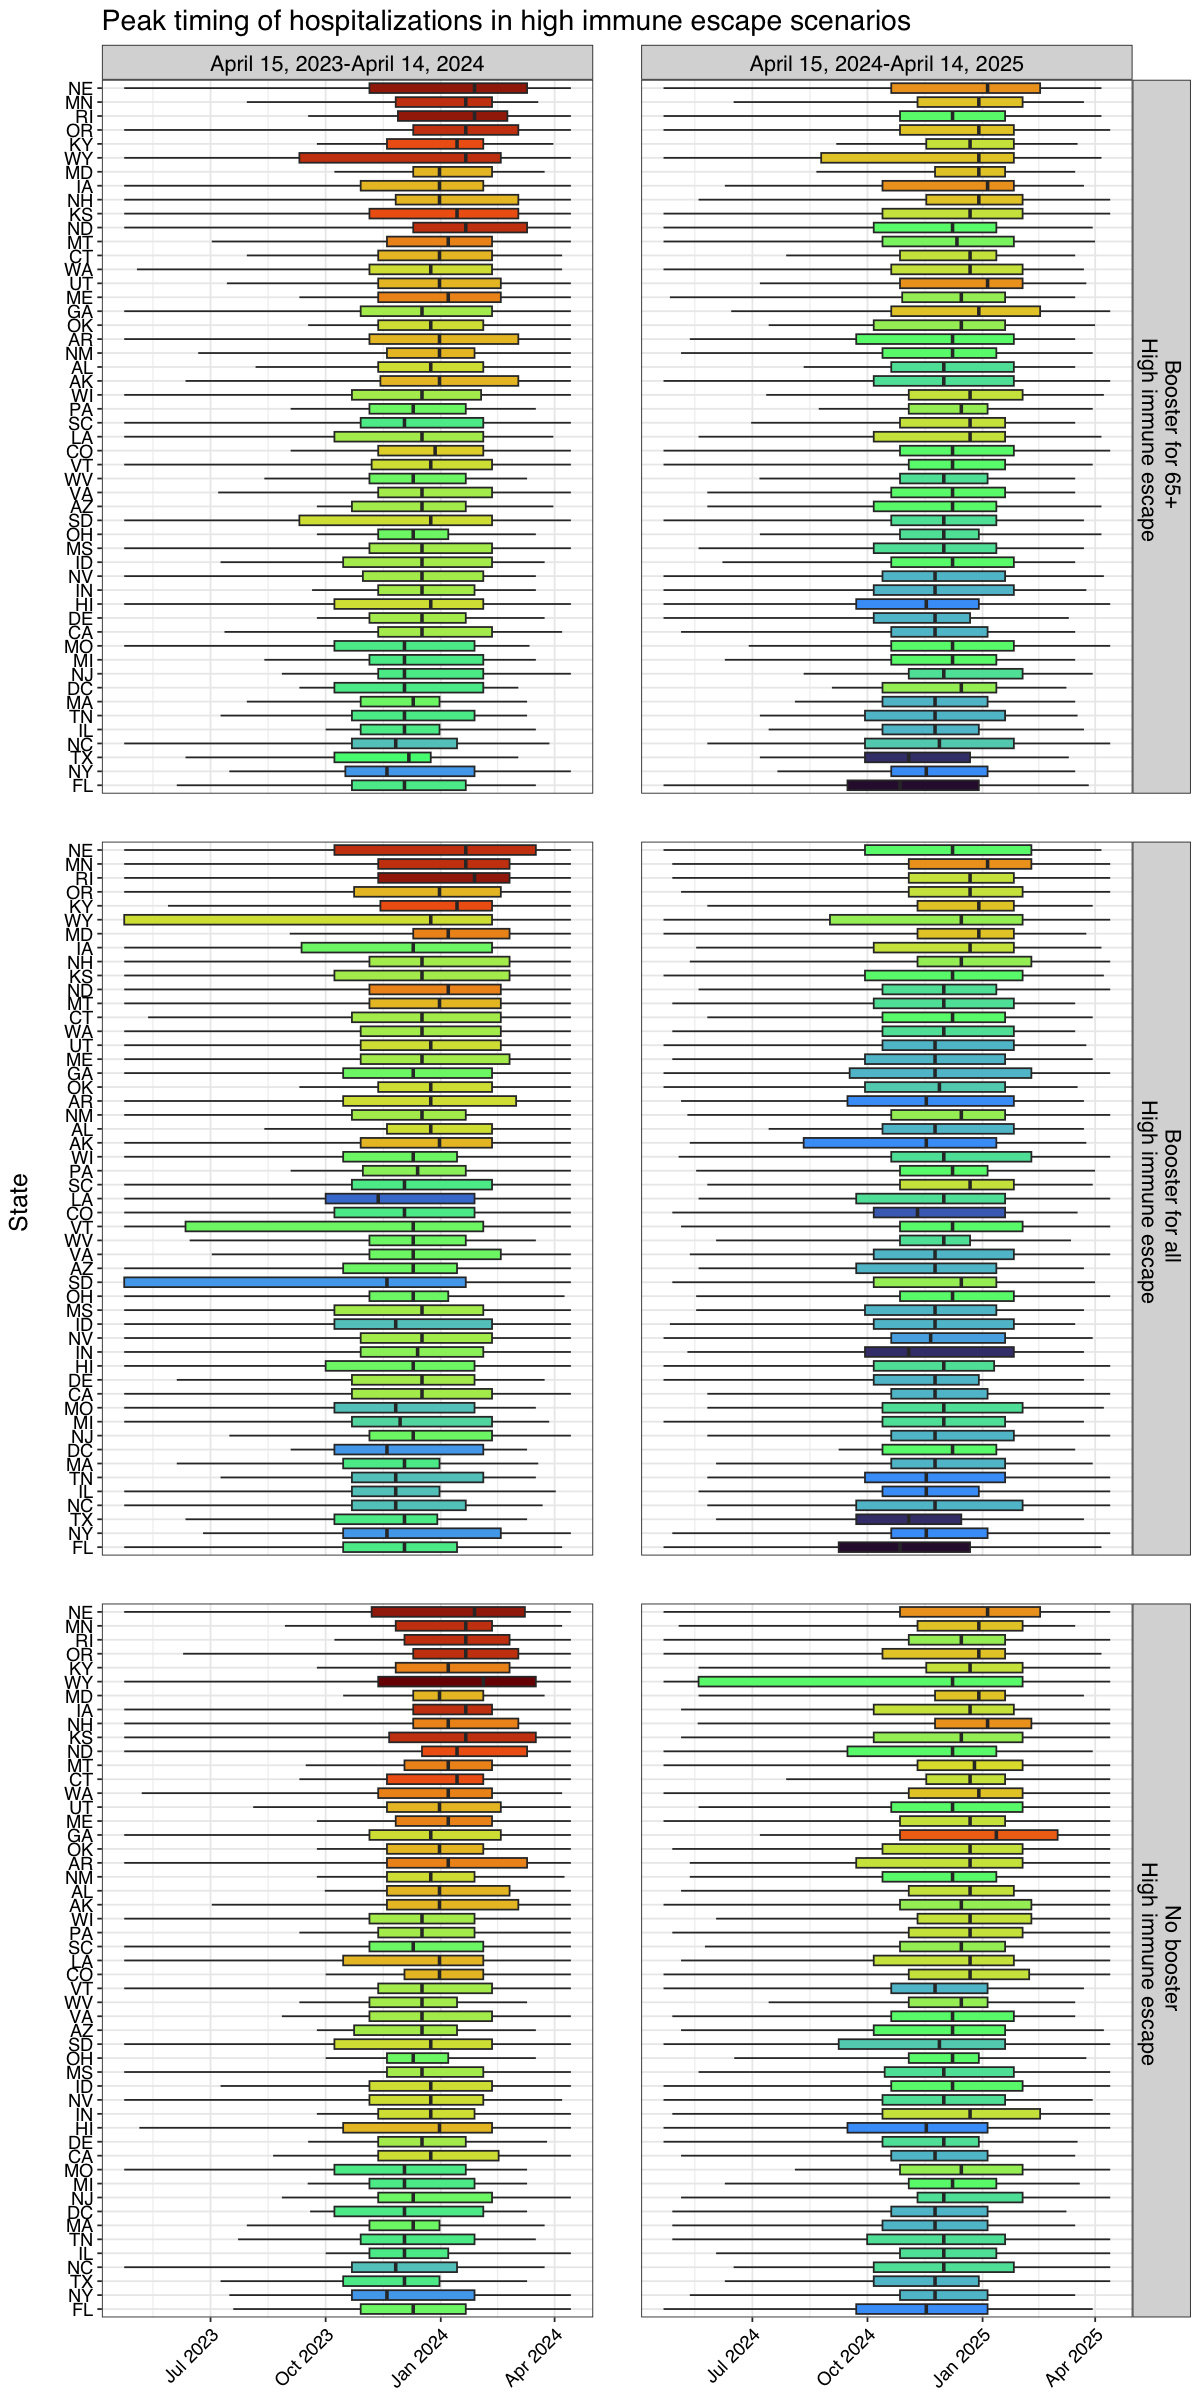

In [22]:
## figure by model
theme_set(theme_bw())
options(repr.plot.width=10,repr.plot.height=20)

rbind(prob_hosp_2023_boxdf_ensemble %>% mutate(season=c("April 15, 2023-April 14, 2024")), 
      prob_hosp_2024_boxdf_ensemble %>% mutate(season=c("April 15, 2024-April 14, 2025"))) %>%
filter(scenario %in% c("No booster \n High immune escape", "Booster for 65+ \n High immune escape",  
                       "Booster for all \n High immune escape")) %>% 
mutate(color=case_when(season==c("April 15, 2023-April 14, 2024")~as.numeric(mx_median-as.Date("2023-10-15")),
                       season==c("April 15, 2024-April 14, 2025")~as.numeric(mx_median-as.Date("2024-10-15")))) %>%
ggplot(aes(x=reorder(abbreviation, mx_median, group=season)))+
geom_boxplot(aes(ymin=mx_q025, lower=mx_q25, middle=mx_median, upper=mx_q75, ymax=mx_q975, 
                 fill=color),
             stat="identity", position = "dodge", width=0.7) +  
facet_grid(rows=vars(scenario), cols=vars(season), scales = "free")+
scale_fill_viridis_c(option = "turbo") +
coord_flip()+
theme(legend.position="none",
      text = element_text(size=15, family="sans",color="black"),
      axis.text = element_text(size=11, family="sans",color="black"),
      plot.title = element_text(size=17, family="sans",color="black"),
      strip.text = element_text(size = 13, family="sans",color="black"),
      axis.title.y = element_text(size=15, family="sans",color="black"),
      axis.text.x = element_text(angle=45, hjust=1), 
      legend.text = element_text(size=14),
      panel.spacing = unit(2, "lines")) +
labs(x="State \n", title="Peak timing of hospitalizations in high immune escape scenarios") -> Fig_timing_state

Fig_timing_state

ggsave("../covid19-scenario-modeling-hub-R17-paper/Figures/FigureSX.tiff", 
       Fig_timing_state, width=10, height=20)

In [23]:
# ## figure by model
# theme_set(theme_bw())
# options(repr.plot.width=10,repr.plot.height=20)

# rbind(prob_hosp_2023_boxdf_ensemble %>% mutate(season=c("2023-2024 season")), 
#       prob_hosp_2024_boxdf_ensemble %>% mutate(season=c("2024-2025 season"))) %>%
# filter(scenario %in% c("No booster \n High immune escape", "Booster for 65+ \n High immune escape",  
#                        "Booster for all \n High immune escape")) %>%
# ggplot(aes(x=reorder(abbreviation, mx_median, group=season)))+
# geom_boxplot(aes(ymin=mx_q025, lower=mx_q25, middle=mx_median, upper=mx_q75, ymax=mx_q975, 
#                  color=mx_median),
#              stat="identity", position = "dodge", width=0.7, alpha=0.5) +  


# facet_grid(rows=vars(scenario), cols=vars(season), scales = "free")+
# scale_color_viridis_c(option = "turbo") +

# coord_flip()+
# theme(legend.position="none",
#       text = element_text(size=15, family="sans",color="black"),
#       axis.text = element_text(size=11, family="sans",color="black"),
#       plot.title = element_text(size=17, family="sans",color="black"),
#       strip.text = element_text(size = 13, family="sans",color="black"),
#       axis.title.y = element_text(size=15, family="sans",color="black"),
#       axis.text.x = element_text(angle=45, hjust=1), 
#       legend.text = element_text(size=14),
#       panel.spacing = unit(2, "lines")) +
# labs(x="State \n", title="Peak timing of hospitalizations in high immune escape scenarios") -> Fig_timing_state

# Fig_timing_state

# ggsave("../covid19-scenario-modeling-hub-R17-paper/Figures/FigureSX.tiff", 
#        Fig_timing_state, width=10, height=20)

### Hospitalizations peak size at the national-level

In [24]:
prob_hosp_2023_df %>%
  group_by(scenario, model_name) %>%
  summarize(mx_median = median(value),
            mx_q975=quantile(unclass(value),prob_list[1]),
            mx_q75=quantile(unclass(value),prob_list[2]),
            mx_q25=quantile(unclass(value),prob_list[3]),
            mx_q025=quantile(unclass(value),prob_list[4]))%>%
  ungroup() -> size_hosp_2023_boxdf

prob_hosp_2024_df %>%
  group_by(scenario, model_name) %>%
  summarize(mx_median = median(value),
            mx_q975=quantile(unclass(value),prob_list[1]),
            mx_q75=quantile(unclass(value),prob_list[2]),
            mx_q25=quantile(unclass(value),prob_list[3]),
            mx_q025=quantile(unclass(value),prob_list[4]))%>%
  ungroup() -> size_hosp_2024_boxdf

prob_hosp_2023_df %>%
  group_by(scenario) %>%
  summarize(mx_median = median(value),
            mx_q975=quantile(unclass(value),prob_list[1]),
            mx_q75=quantile(unclass(value),prob_list[2]),
            mx_q25=quantile(unclass(value),prob_list[3]),
            mx_q025=quantile(unclass(value),prob_list[4]))%>%
  ungroup() %>% mutate(model_name=c("Ensemble")) -> size_hosp_2023_boxdf_ensemble

prob_hosp_2024_df %>%
  group_by(scenario) %>%
  summarize(mx_median = median(value),
            mx_q975=quantile(unclass(value),prob_list[1]),
            mx_q75=quantile(unclass(value),prob_list[2]),
            mx_q25=quantile(unclass(value),prob_list[3]),
            mx_q025=quantile(unclass(value),prob_list[4]))%>%
  ungroup() %>% mutate(model_name=c("Ensemble")) -> size_hosp_2024_boxdf_ensemble


rbind(size_hosp_2023_boxdf, size_hosp_2023_boxdf_ensemble) %>%
arrange(scenario, factor(model_name, 
                         levels=c("UVA-adaptive", "UTA-ImmunoSEIRS", "USC-SIkJalpha", "UNCC-hierbin", 
                                  "MOBS_NEU-GLEAM_COVID", "JHU_IDD_CovidSP", "Ensemble"))) -> size_hosp_2023_boxdf

rbind(size_hosp_2024_boxdf, size_hosp_2024_boxdf_ensemble) %>%
arrange(scenario, factor(model_name, 
                         levels=c("UVA-adaptive", "UTA-ImmunoSEIRS", "USC-SIkJalpha", "UNCC-hierbin", 
                                  "MOBS_NEU-GLEAM_COVID", "JHU_IDD_CovidSP", "Ensemble"))) -> size_hosp_2024_boxdf

`summarise()` has grouped output by 'scenario'. You can override using the
`.groups` argument.
`summarise()` has grouped output by 'scenario'. You can override using the
`.groups` argument.


In [25]:
size_hosp_2023_boxdf$scenario <- factor(size_hosp_2023_boxdf$scenario, 
levels=c("No booster \n Low immune escape", "No booster \n High immune escape",
         "Booster for 65+ \n Low immune escape", "Booster for 65+ \n High immune escape",
         "Booster for all \n Low immune escape", "Booster for all \n High immune escape"))

size_hosp_2024_boxdf$scenario <- factor(size_hosp_2024_boxdf$scenario, 
levels=c("No booster \n Low immune escape", "No booster \n High immune escape",
         "Booster for 65+ \n Low immune escape", "Booster for 65+ \n High immune escape",
         "Booster for all \n Low immune escape", "Booster for all \n High immune escape"))

In [26]:
## table
rbind(size_hosp_2023_boxdf %>% mutate(season=c("2023-2024 season")), 
      size_hosp_2024_boxdf %>% mutate(season=c("2024-2025 season"))) %>%
filter(model_name==c("Ensemble")) -> peak_size_ensemble

peak_size_ensemble

scenario,model_name,mx_median,mx_q975,mx_q75,mx_q25,mx_q025,season
<fct>,<chr>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<chr>
Booster for 65+ High immune escape,Ensemble,39051.82,96007.28,54218.82,25597.88,15667.22,2023-2024 season
Booster for 65+ Low immune escape,Ensemble,33530.00,74906.49,43777.85,21237.91,13157.70,2023-2024 season
Booster for all High immune escape,Ensemble,35146.20,94949.74,43900.33,21754.00,13975.40,2023-2024 season
Booster for all Low immune escape,Ensemble,26222.00,64121.48,35902.18,18383.77,10962.49,2023-2024 season
No booster High immune escape,Ensemble,41689.64,110295.33,63383.70,26815.28,16640.45,2023-2024 season
No booster Low immune escape,Ensemble,36292.00,89327.57,53107.74,23150.12,14468.93,2023-2024 season
Booster for 65+ High immune escape,Ensemble,41366.45,83432.21,55037.73,23400.99,14610.62,2024-2025 season
Booster for 65+ Low immune escape,Ensemble,32256.00,74308.90,42382.43,18811.10,12163.83,2024-2025 season
Booster for all High immune escape,Ensemble,32403.00,80927.82,49598.91,20176.00,12167.43,2024-2025 season


In [27]:
read.csv("../covid19-scenario-hub_analysis/data-locations/locations.csv") %>% 
filter(!(abbreviation%in%c("US", "AS", "GU", "MP", "PR", "UM", "VI"))) %>%
mutate(USpopsize=sum(population)) -> temp_pop

as.numeric(unique(temp_pop$USpopsize)) -> USpopsize

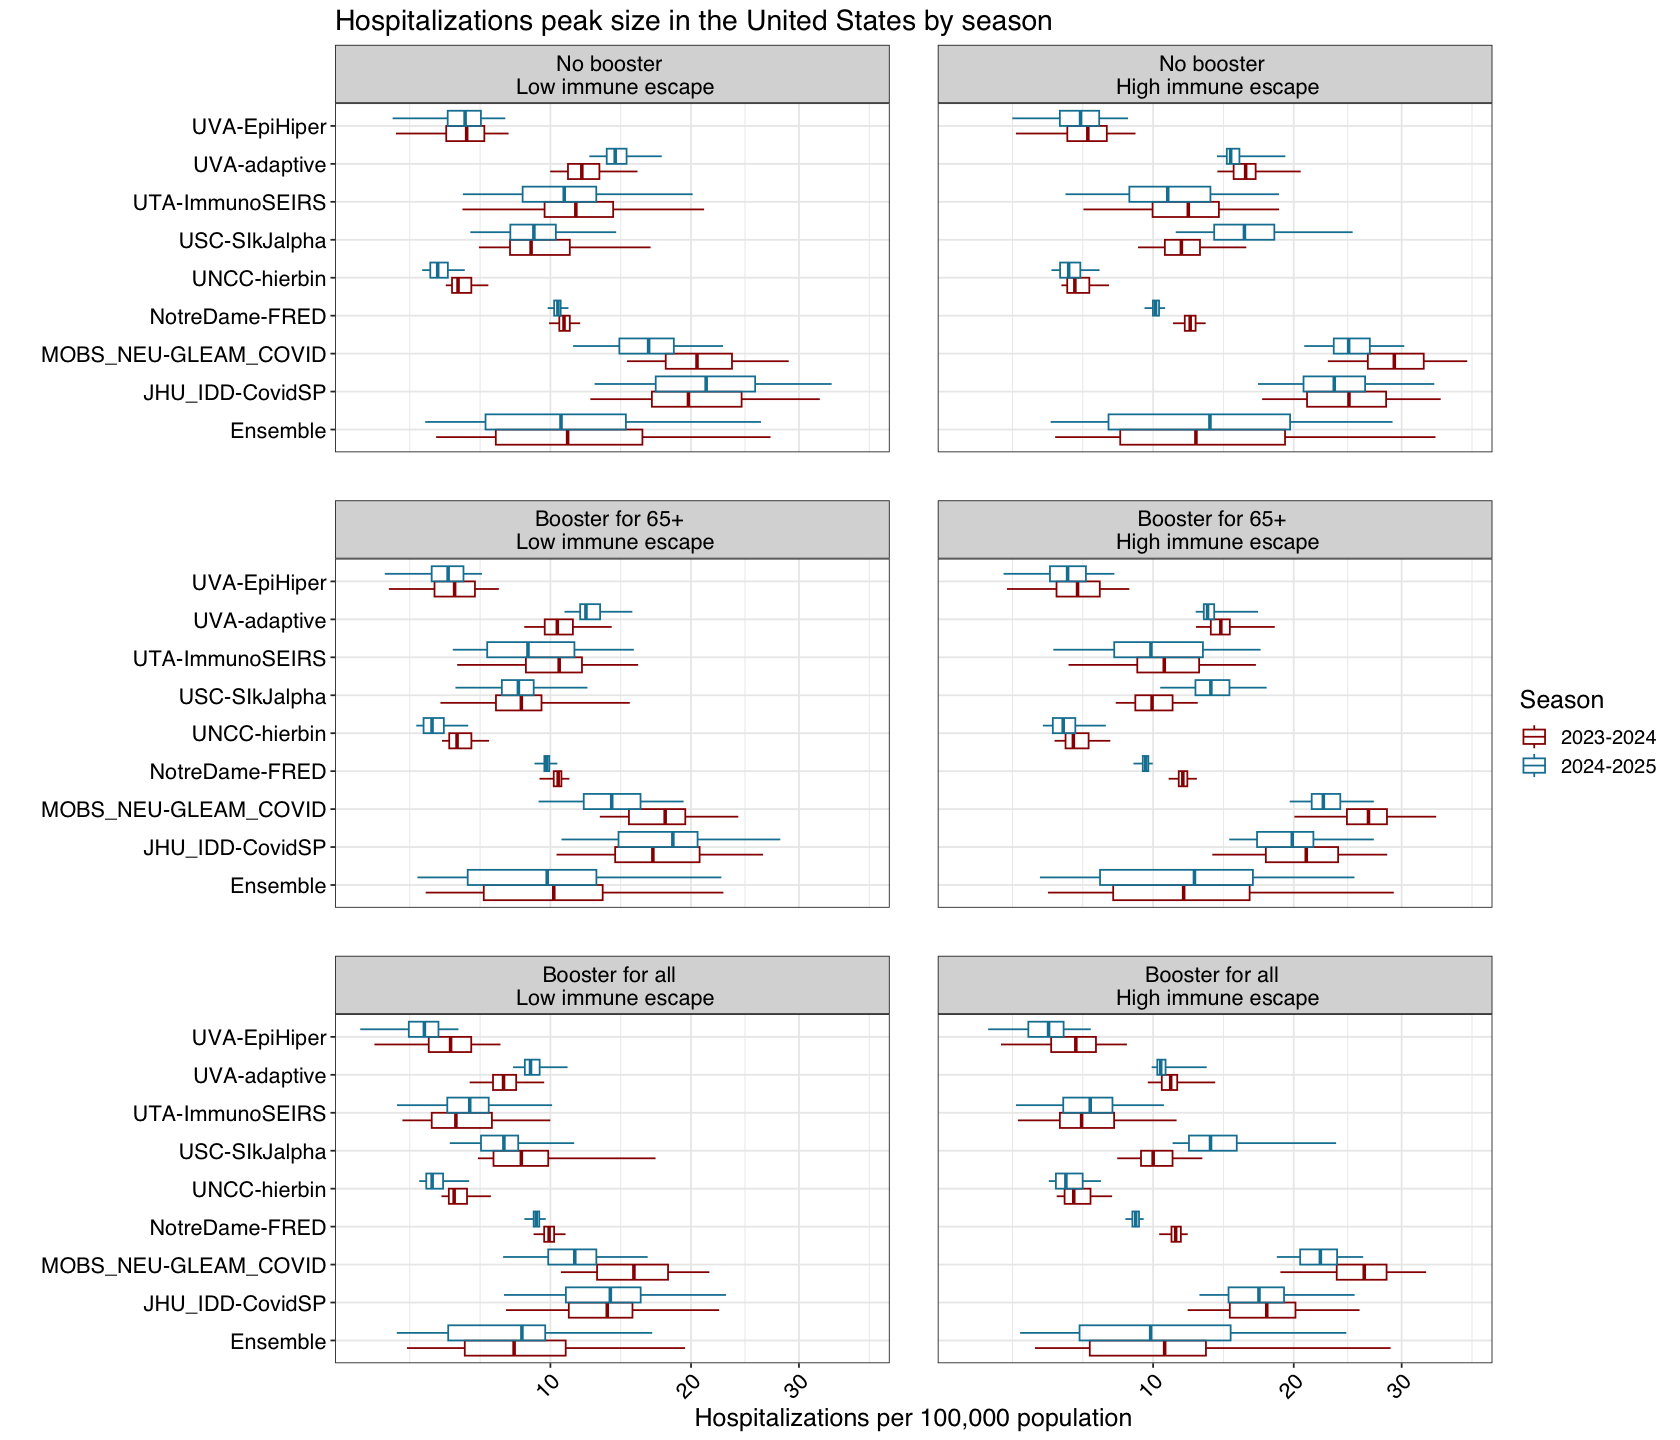

In [28]:
## figure by model
theme_set(theme_bw())
options(repr.plot.width=14,repr.plot.height=12)

rbind(size_hosp_2023_boxdf %>% mutate(season=c("2023-2024")), 
      size_hosp_2024_boxdf %>% mutate(season=c("2024-2025"))) %>%
ggplot(aes(x=model_name))+
facet_wrap(~scenario, nrow = 3)+
geom_boxplot(aes(ymin=mx_q025/USpopsize*100000, lower=mx_q25/USpopsize*100000, middle=mx_median/USpopsize*100000, 
                 upper=mx_q75/USpopsize*100000, ymax=mx_q975/USpopsize*100000, color=season),
             stat="identity", position = "dodge", width=0.8, alpha=0.5) +  
scale_color_manual("Season", values=c("#990000","#1380A1")) +
coord_flip()+
scale_y_sqrt()+
theme(text = element_text(size=15, family="sans",color="black"),
      axis.text = element_text(size=13, family="sans",color="black"),
      plot.title = element_text(size=17, family="sans",color="black"),
      strip.text = element_text(size = 13, family="sans",color="black"),
      axis.text.x = element_text(angle=45, hjust=1),
      panel.spacing = unit(2, "lines")) +
labs(x="", y="Hospitalizations per 100,000 population", 
     title="Hospitalizations peak size in the United States by season") -> peak_size_hosp

peak_size_hosp

### Total hospitalizations and deaths at the national-level

In [29]:
df_sample_date_total <- df_sample %>% filter(location=="US") %>% 
group_by(scenario_id, target, model_name, period, type_id) %>% mutate(cum_value=cumsum(value)) %>% 
slice(which.max(cum_value)) %>% ungroup()

In [30]:
df_sample_date_total %>% filter(target=="inc hosp") %>%
mutate(scenario=recode(scenario_id, 
                       "A-2023-04-16" = "No booster \n Low immune escape", 
                       "B-2023-04-16" = "No booster \n High immune escape", 
                       "C-2023-04-16"="Booster for 65+ \n Low immune escape", 
                       "D-2023-04-16"="Booster for 65+ \n High immune escape", 
                       "E-2023-04-16"="Booster for all \n Low immune escape",
                       "F-2023-04-16"="Booster for all \n High immune escape")) %>%
filter(period=="season 2023-24") -> total_hosp_2023_df

df_sample_date_total %>% filter(target=="inc hosp") %>%
mutate(scenario=recode(scenario_id, 
                       "A-2023-04-16" = "No booster \n Low immune escape", 
                       "B-2023-04-16" = "No booster \n High immune escape", 
                       "C-2023-04-16"="Booster for 65+ \n Low immune escape", 
                       "D-2023-04-16"="Booster for 65+ \n High immune escape", 
                       "E-2023-04-16"="Booster for all \n Low immune escape",
                       "F-2023-04-16"="Booster for all \n High immune escape")) %>%
filter(period=="season 2024-25"& proj_date <= as.Date("2025-04-19")) -> total_hosp_2024_df

df_sample_date_total %>% filter(target=="inc death") %>%
mutate(scenario=recode(scenario_id, 
                       "A-2023-04-16" = "No booster \n Low immune escape", 
                       "B-2023-04-16" = "No booster \n High immune escape", 
                       "C-2023-04-16"="Booster for 65+ \n Low immune escape", 
                       "D-2023-04-16"="Booster for 65+ \n High immune escape", 
                       "E-2023-04-16"="Booster for all \n Low immune escape",
                       "F-2023-04-16"="Booster for all \n High immune escape")) %>%
filter(period=="season 2023-24") -> total_death_2023_df

df_sample_date_total %>% filter(target=="inc death") %>%
mutate(scenario=recode(scenario_id, 
                       "A-2023-04-16" = "No booster \n Low immune escape", 
                       "B-2023-04-16" = "No booster \n High immune escape", 
                       "C-2023-04-16"="Booster for 65+ \n Low immune escape", 
                       "D-2023-04-16"="Booster for 65+ \n High immune escape", 
                       "E-2023-04-16"="Booster for all \n Low immune escape",
                       "F-2023-04-16"="Booster for all \n High immune escape")) %>%
filter(period=="season 2024-25"& proj_date <= as.Date("2025-04-19")) -> total_death_2024_df

In [31]:
total_hosp_2023_df %>%
  group_by(scenario, model_name) %>%
  summarize(mx_median = median(cum_value),
            mx_q975=quantile(unclass(cum_value),prob_list[1]),
            mx_q75=quantile(unclass(cum_value),prob_list[2]),
            mx_q25=quantile(unclass(cum_value),prob_list[3]),
            mx_q025=quantile(unclass(cum_value),prob_list[4])) %>% ungroup() -> total_hosp_2023_boxdf

total_hosp_2024_df %>%
  group_by(scenario, model_name) %>%
  summarize(mx_median = median(cum_value),
            mx_q975=quantile(unclass(cum_value),prob_list[1]),
            mx_q75=quantile(unclass(cum_value),prob_list[2]),
            mx_q25=quantile(unclass(cum_value),prob_list[3]),
            mx_q025=quantile(unclass(cum_value),prob_list[4])) %>% ungroup() -> total_hosp_2024_boxdf

total_hosp_2023_df %>%
  group_by(scenario) %>%
  summarize(mx_median = median(cum_value),
            mx_q975=quantile(unclass(cum_value),prob_list[1]),
            mx_q75=quantile(unclass(cum_value),prob_list[2]),
            mx_q25=quantile(unclass(cum_value),prob_list[3]),
            mx_q025=quantile(unclass(cum_value),prob_list[4]))%>% ungroup() %>% 
mutate(model_name=c("Ensemble")) -> total_hosp_2023_boxdf_ensemble

total_hosp_2024_df %>%
  group_by(scenario) %>%
  summarize(mx_median = median(cum_value),
            mx_q975=quantile(unclass(cum_value),prob_list[1]),
            mx_q75=quantile(unclass(cum_value),prob_list[2]),
            mx_q25=quantile(unclass(cum_value),prob_list[3]),
            mx_q025=quantile(unclass(cum_value),prob_list[4]))%>% ungroup() %>% 
mutate(model_name=c("Ensemble")) -> total_hosp_2024_boxdf_ensemble


rbind(total_hosp_2023_boxdf, total_hosp_2023_boxdf_ensemble) %>%
arrange(scenario, factor(model_name, 
                         levels=c("UVA-adaptive", "UTA-ImmunoSEIRS", "USC-SIkJalpha", "UNCC-hierbin", 
                                  "MOBS_NEU-GLEAM_COVID", "JHU_IDD_CovidSP", "Ensemble"))) -> total_hosp_2023_boxdf

rbind(total_hosp_2024_boxdf, total_hosp_2024_boxdf_ensemble) %>%
arrange(scenario, factor(model_name, 
                         levels=c("UVA-adaptive", "UTA-ImmunoSEIRS", "USC-SIkJalpha", "UNCC-hierbin", 
                                  "MOBS_NEU-GLEAM_COVID", "JHU_IDD_CovidSP", "Ensemble"))) -> total_hosp_2024_boxdf

`summarise()` has grouped output by 'scenario'. You can override using the
`.groups` argument.
`summarise()` has grouped output by 'scenario'. You can override using the
`.groups` argument.


In [32]:
total_death_2023_df %>%
  group_by(scenario, model_name) %>%
  summarize(mx_median = median(cum_value),
            mx_q975=quantile(unclass(cum_value),prob_list[1]),
            mx_q75=quantile(unclass(cum_value),prob_list[2]),
            mx_q25=quantile(unclass(cum_value),prob_list[3]),
            mx_q025=quantile(unclass(cum_value),prob_list[4]))%>% ungroup() -> total_death_2023_boxdf

total_death_2024_df %>%
  group_by(scenario, model_name) %>%
  summarize(mx_median = median(cum_value),
            mx_q975=quantile(unclass(cum_value),prob_list[1]),
            mx_q75=quantile(unclass(cum_value),prob_list[2]),
            mx_q25=quantile(unclass(cum_value),prob_list[3]),
            mx_q025=quantile(unclass(cum_value),prob_list[4]))%>% ungroup() -> total_death_2024_boxdf

total_death_2023_df %>%
  group_by(scenario) %>%
  summarize(mx_median = median(cum_value),
            mx_q975=quantile(unclass(cum_value),prob_list[1]),
            mx_q75=quantile(unclass(cum_value),prob_list[2]),
            mx_q25=quantile(unclass(cum_value),prob_list[3]),
            mx_q025=quantile(unclass(cum_value),prob_list[4]))%>% ungroup() %>% 
mutate(model_name=c("Ensemble")) -> total_death_2023_boxdf_ensemble

total_death_2024_df %>%
  group_by(scenario) %>%
  summarize(mx_median = median(cum_value),
            mx_q975=quantile(unclass(cum_value),prob_list[1]),
            mx_q75=quantile(unclass(cum_value),prob_list[2]),
            mx_q25=quantile(unclass(cum_value),prob_list[3]),
            mx_q025=quantile(unclass(cum_value),prob_list[4]))%>% ungroup() %>% 
mutate(model_name=c("Ensemble")) -> total_death_2024_boxdf_ensemble


rbind(total_death_2023_boxdf, total_death_2023_boxdf_ensemble) %>%
arrange(scenario, factor(model_name, 
                         levels=c("UVA-adaptive", "UTA-ImmunoSEIRS", "USC-SIkJalpha", "UNCC-hierbin", 
                                  "MOBS_NEU-GLEAM_COVID", "JHU_IDD_CovidSP", "Ensemble"))) -> total_death_2023_boxdf

rbind(total_death_2024_boxdf, total_death_2024_boxdf_ensemble) %>%
arrange(scenario, factor(model_name, 
                         levels=c("UVA-adaptive", "UTA-ImmunoSEIRS", "USC-SIkJalpha", "UNCC-hierbin", 
                                  "MOBS_NEU-GLEAM_COVID", "JHU_IDD_CovidSP", "Ensemble"))) -> total_death_2024_boxdf

`summarise()` has grouped output by 'scenario'. You can override using the
`.groups` argument.
`summarise()` has grouped output by 'scenario'. You can override using the
`.groups` argument.


In [33]:
total_hosp_2023_boxdf$scenario <- factor(total_hosp_2023_boxdf$scenario, 
levels=c("No booster \n Low immune escape", "No booster \n High immune escape",
         "Booster for 65+ \n Low immune escape", "Booster for 65+ \n High immune escape",
         "Booster for all \n Low immune escape", "Booster for all \n High immune escape"))

total_hosp_2024_boxdf$scenario <- factor(total_hosp_2024_boxdf$scenario, 
levels=c("No booster \n Low immune escape", "No booster \n High immune escape",
         "Booster for 65+ \n Low immune escape", "Booster for 65+ \n High immune escape",
         "Booster for all \n Low immune escape", "Booster for all \n High immune escape"))

total_death_2023_boxdf$scenario <- factor(total_death_2023_boxdf$scenario, 
levels=c("No booster \n Low immune escape", "No booster \n High immune escape",
         "Booster for 65+ \n Low immune escape", "Booster for 65+ \n High immune escape",
         "Booster for all \n Low immune escape", "Booster for all \n High immune escape"))

total_death_2024_boxdf$scenario <- factor(total_death_2024_boxdf$scenario, 
levels=c("No booster \n Low immune escape", "No booster \n High immune escape",
         "Booster for 65+ \n Low immune escape", "Booster for 65+ \n High immune escape",
         "Booster for all \n Low immune escape", "Booster for all \n High immune escape"))

In [34]:
## table
rbind(total_hosp_2023_boxdf %>% mutate(season=c("2023-2024 season")), 
      total_hosp_2024_boxdf %>% mutate(season=c("2024-2025 season"))) %>%
filter(model_name==c("Ensemble")) -> total_hosp_ensemble

rbind(total_death_2023_boxdf %>% mutate(season=c("2023-2024 season")), 
      total_death_2024_boxdf %>% mutate(season=c("2024-2025 season"))) %>%
filter(model_name==c("Ensemble")) -> total_death_ensemble

total_hosp_ensemble
total_death_ensemble

scenario,model_name,mx_median,mx_q975,mx_q75,mx_q25,mx_q025,season
<fct>,<chr>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<chr>
Booster for 65+ High immune escape,Ensemble,921948.5,2081596,1507666.0,768090.2,405355.4,2023-2024 season
Booster for 65+ Low immune escape,Ensemble,777809.5,1247825,919756.7,659783.0,298068.8,2023-2024 season
Booster for all High immune escape,Ensemble,834599.0,1981891,1420485.0,684268.3,391397.3,2023-2024 season
Booster for all Low immune escape,Ensemble,683979.3,1076873,799188.5,581600.2,273322.4,2023-2024 season
No booster High immune escape,Ensemble,1001209.5,2262540,1695778.5,828374.4,440639.2,2023-2024 season
No booster Low immune escape,Ensemble,812304.0,1416283,1064632.3,735240.3,335928.0,2023-2024 season
Booster for 65+ High immune escape,Ensemble,1038893.5,2727537,1790418.6,675980.5,393370.1,2024-2025 season
Booster for 65+ Low immune escape,Ensemble,862305.6,1250844,1020626.3,536046.4,281219.2,2024-2025 season
Booster for all High immune escape,Ensemble,972442.2,2655780,1620629.3,605809.1,326841.9,2024-2025 season


scenario,model_name,mx_median,mx_q975,mx_q75,mx_q25,mx_q025,season
<fct>,<chr>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<chr>
Booster for 65+ High immune escape,Ensemble,95107.22,210874.9,158342.89,67046.50,46059.01,2023-2024 season
Booster for 65+ Low immune escape,Ensemble,70847.84,116477.5,101768.34,59552.17,34396.30,2023-2024 season
Booster for all High immune escape,Ensemble,82472.40,200714.3,152401.84,63545.79,39422.94,2023-2024 season
Booster for all Low immune escape,Ensemble,63141.76,110102.1,90852.93,53381.81,28147.65,2023-2024 season
No booster High immune escape,Ensemble,101699.79,236611.4,191678.77,77035.23,53534.11,2023-2024 season
No booster Low immune escape,Ensemble,79628.81,145555.0,113862.05,68503.10,38096.49,2023-2024 season
Booster for 65+ High immune escape,Ensemble,100077.95,284417.0,175461.65,62374.40,35767.36,2024-2025 season
Booster for 65+ Low immune escape,Ensemble,79740.51,169093.0,103531.33,47282.60,27218.11,2024-2025 season
Booster for all High immune escape,Ensemble,90133.66,277279.7,162225.50,58291.69,28462.17,2024-2025 season


### Final format of Table 1

In [35]:
interval <- c("mx_q975", "mx_q025")

peak_timing_ensemble %>% dplyr::rename(timing_med=mx_median, timing_ub=interval[1], timing_lb=interval[2]) %>%
dplyr::select(scenario, season, timing_lb, timing_med, timing_ub) -> timing_table

peak_size_ensemble %>% dplyr::rename(size_med=mx_median, size_ub=interval[1], size_lb=interval[2]) %>%
dplyr::select(scenario, season, size_lb, size_med, size_ub) -> size_table

total_hosp_ensemble %>% dplyr::rename(hosp_med=mx_median, hosp_ub=interval[1], hosp_lb=interval[2]) %>%
dplyr::select(scenario, season, hosp_lb, hosp_med, hosp_ub) -> total_hosp_table

total_death_ensemble %>%dplyr:: rename(death_med=mx_median, death_ub=interval[1], death_lb=interval[2]) %>%
dplyr::select(scenario, season, death_lb, death_med, death_ub) -> total_death_table

list_df = list(timing_table, size_table, total_hosp_table, total_death_table)
Reduce(function(x, y) merge(x, y, by=c("scenario", "season")), list_df) %>% filter(season==c("2023-2024 season")) %>%
       mutate(timing=paste0(format(timing_med, format=c("%b%d"))," (",format(timing_lb, format=c("%b%d")),"-",
                            format(timing_ub, format=c("%b%d")),")"),
              size=paste0(round(size_med)," (", round(size_lb), "-", round(size_ub), ")"),
              total_hosp=paste0(round(hosp_med)," (", round(hosp_lb), "-", round(hosp_ub), ")"),
              total_death=paste0(round(death_med)," (", round(death_lb), "-", round(death_ub), ")")) %>%
       dplyr::select(scenario, season, timing, size, total_hosp, total_death)
       
       list_df = list(timing_table, size_table, total_hosp_table, total_death_table)
Reduce(function(x, y) merge(x, y, by=c("scenario", "season")), list_df) %>% filter(season==c("2024-2025 season")) %>%
       mutate(timing=paste0(format(timing_med, format=c("%b%d"))," (",format(timing_lb, format=c("%b%d")),"-",
                            format(timing_ub, format=c("%b%d")),")"),
              size=paste0(round(size_med)," (", round(size_lb), "-", round(size_ub), ")"),
              total_hosp=paste0(round(hosp_med)," (", round(hosp_lb), "-", round(hosp_ub), ")"),
              total_death=paste0(round(death_med)," (", round(death_lb), "-", round(death_ub), ")")) %>%
       dplyr::select(scenario, season, timing, size, total_hosp, total_death)

scenario,season,timing,size,total_hosp,total_death
<fct>,<chr>,<chr>,<chr>,<chr>,<chr>
Booster for 65+ High immune escape,2023-2024 season,Dec10 (Oct08-Feb11),39052 (15667-96007),921948 (405355-2081596),95107 (46059-210875)
Booster for 65+ Low immune escape,2023-2024 season,Dec10 (May05-Mar10),33530 (13158-74906),777810 (298069-1247825),70848 (34396-116478)
Booster for all High immune escape,2023-2024 season,Dec10 (Sep29-Mar24),35146 (13975-94950),834599 (391397-1981891),82472 (39423-200714)
Booster for all Low immune escape,2023-2024 season,Dec03 (Apr28-Mar10),26222 (10962-64121),683979 (273322-1076873),63142 (28148-110102)
No booster High immune escape,2023-2024 season,Dec10 (Oct15-Apr14),41690 (16640-110295),1001210 (440639-2262540),101700 (53534-236611)
No booster Low immune escape,2023-2024 season,Dec13 (Jun11-Apr14),36292 (14469-89328),812304 (335928-1416283),79629 (38096-145555)


scenario,season,timing,size,total_hosp,total_death
<fct>,<chr>,<chr>,<chr>,<chr>,<chr>
Booster for 65+ High immune escape,2024-2025 season,Dec15 (Oct06-Mar10),41366 (14611-83432),1038894 (393370-2727537),100078 (35767-284417)
Booster for 65+ Low immune escape,2024-2025 season,Dec22 (Oct20-Mar09),32256 (12164-74309),862306 (281219-1250844),79741 (27218-169093)
Booster for all High immune escape,2024-2025 season,Dec08 (May31-Mar03),32403 (12167-80928),972442 (326842-2655780),90134 (28462-277280)
Booster for all Low immune escape,2024-2025 season,Dec15 (Jun02-Mar09),27588 (9854-55541),722941 (213934-1061497),70405 (18572-155030)
No booster High immune escape,2024-2025 season,Dec15 (May12-Apr13),44799 (16029-95588),1080360 (442585-2893995),120706 (49182-304913)
No booster Low immune escape,2024-2025 season,Dec29 (Jun09-Apr13),34960 (13102-86298),1007473 (327860-1515214),85843 (42989-178253)


# Figure S1: National cumulative hospitalizations and deaths

In [36]:
dir_path <- c("../covid19-scenario-hub_analysis/")
data_path <- c("../covid19-megaround_data/")


## choose scenario identifier and appropriate hosp file
scenario.id="04-16"
projection.start.date="2023-04-15"
projection.end.date <- "2025-04-19"
round <- 17
ens_choice <- "Ensemble_LOP"
pi_low <- 0.025
pi_high <- 0.975  

model_names <- c("Ensemble",
                 "Ensemble_LOP",
                 "Ensemble_LOP_untrimmed",
                 "JHU_IDD-CovidSP",
                 "MOBS_NEU-GLEAM_COVID",
                 "NCSU-COVSIM",
                 "NotreDame-FRED",
                 "UNCC-hierbin",
                 "USC-SIkJalpha",
                 "UTA-ImmunoSEIRS",
                 "UVA-adaptive",
                 "UVA-EpiHiper")

source("../covid19-scenario-hub_analysis/code/R/read_data_files.R", local = knitr::knit_global())
source("../covid19-scenario-hub_analysis/code/report/collect_data_update.R", local = knitr::knit_global())

# Scenario name information - UPDATE EACH ROUND
axis1 <- c("noBoo", "65Boo", "allBoo")
axis2 <- c("lowIE", "highIE")
axis1_long <- c("No booster", "Booster for 65+", "Booster for all")
axis2_long <- c("Low immune escape", "High immune escape") 
var_name1 <- "IE"
var_name2 <- "boo"
pessimistic <- "noBoo_highIE" # most pessimistic scenario to use for risk maps

s1.1 <- paste(axis1[1], axis2[1], sep = "_")
s2.1 <- paste(axis1[2], axis2[1], sep = "_")
s3.1 <- paste(axis1[3], axis2[1], sep = "_")
s1.2 <- paste(axis1[1], axis2[2], sep = "_")
s2.2 <- paste(axis1[2], axis2[2], sep = "_")
s3.2 <- paste(axis1[3], axis2[2], sep = "_")

# some columns to use for plotting
x_ci$model <- factor(x_ci$model, levels = model_names)
x_ci$scenario_name <- recode(x_ci$scenario_id,
                             "A-2023-04-16" = "noBoo_lowIE",
                             "B-2023-04-16" = "noBoo_highIE",
                             "C-2023-04-16" = "65Boo_lowIE",
                             "D-2023-04-16" = "65Boo_highIE",
                             "E-2023-04-16" = "allBoo_lowIE",
                             "F-2023-04-16" = "allBoo_highIE")

x_ci$a1 <- ifelse(x_ci$scenario_name %in% c(s1.1, s1.2), axis1_long[1],
                  ifelse(x_ci$scenario_name %in% c(s2.1, s2.2), axis1_long[2], axis1_long[3]))
x_ci$a1 <- factor(x_ci$a1, levels =c(axis1_long[1], axis1_long[2], axis1_long[3]))
x_ci$a2 <- ifelse(x_ci$scenario_name %in% c(s1.1, s2.1, s3.1), axis2_long[1], axis2_long[2])
x_ci$a2 <- factor(x_ci$a2, levels = c(axis2_long[1], axis2_long[2]))
x_ci$full_scenario <- paste(x_ci$a1, x_ci$a2, sep = ", ")

x$model <- factor(x$model, levels = model_names)
x$scenario_name <- recode(x$scenario_id,
                          "A-2023-04-16" = "noBoo_lowIE",
                          "B-2023-04-16" = "noBoo_highIE",
                          "C-2023-04-16" = "65Boo_lowIE",
                          "D-2023-04-16" = "65Boo_highIE",
                          "E-2023-04-16" = "allBoo_lowIE",
                          "F-2023-04-16" = "allBoo_highIE")
x$a1 <- ifelse(x$scenario_name %in% c(s1.1, s1.2), axis1_long[1],
               ifelse(x$scenario_name %in% c(s2.1, s2.2), axis1_long[2], axis1_long[3]))
x$a1 <- factor(x$a1, levels =c(axis1_long[1], axis1_long[2], axis1_long[3]))
x$a2 <- ifelse(x$scenario_name %in% c(s1.1, s2.1, s3.1), axis2_long[1], axis2_long[2])
x$a2 <- factor(x$a2, levels = c(axis2_long[1], axis2_long[2]))
x$full_scenario <- paste(x$a1, x$a2, sep = ", ")

# filter out projections beyond 26 weeks
x <- x %>% filter(target_end_date <= as.Date(projection.end.date))
x_ci <- x_ci %>% filter(target_end_date <= as.Date(projection.end.date))

Loading required package: reshape


Attaching package: ‘reshape’


The following object is masked from ‘package:data.table’:

    melt


The following objects are masked from ‘package:reshape2’:

    colsplit, melt, recast


The following object is masked from ‘package:lubridate’:

    stamp


The following object is masked from ‘package:dplyr’:

    rename


The following objects are masked from ‘package:tidyr’:

    expand, smiths


Joining with `by = join_by(location)`
Joining with `by = join_by(origin_date, scenario_id, location, target, horizon,
model, target_end_date, abbreviation, location_name, population, target_type)`
Joining with `by = join_by(origin_date, scenario_id, location, target, horizon,
model, target_end_date, abbreviation, location_name, population, target_type)`


In [37]:
temp <- x_ci %>% filter(str_detect(target, "cum"), location == "US", model == "Ensemble")
# temp %>% head()
temp %>% filter(target_type=="Deaths" & 
                full_scenario=="No booster, High immune escape") %>% slice(which.max(target_end_date)) 

origin_date,scenario_id,location,target,horizon,model,value,target_end_date,abbreviation,location_name,population,target_type,lower,upper,scenario_name,a1,a2,full_scenario
<date>,<chr>,<chr>,<chr>,<dbl>,<fct>,<dbl>,<date>,<fct>,<fct>,<dbl>,<chr>,<dbl>,<dbl>,<chr>,<fct>,<fct>,<chr>
2023-04-16,B-2023-04-16,US,cum death,104,Ensemble,208683,2025-04-12,US,US,328728466,Deaths,137511.3,478845.2,noBoo_highIE,No booster,High immune escape,"No booster, High immune escape"


In [38]:
x_ci %>% filter(location == "US", model == "Ensemble") %>% head()

origin_date,scenario_id,location,target,horizon,model,value,target_end_date,abbreviation,location_name,population,target_type,lower,upper,scenario_name,a1,a2,full_scenario
<date>,<chr>,<chr>,<chr>,<dbl>,<fct>,<dbl>,<date>,<fct>,<fct>,<dbl>,<chr>,<dbl>,<dbl>,<chr>,<fct>,<fct>,<chr>
2023-04-16,A-2023-04-16,US,cum death,1,Ensemble,1209.039,2023-04-22,US,US,328728466,Deaths,1006.372,2007.650,noBoo_lowIE,No booster,Low immune escape,"No booster, Low immune escape"
2023-04-16,A-2023-04-16,US,cum death,2,Ensemble,2359.991,2023-04-29,US,US,328728466,Deaths,1922.045,3747.475,noBoo_lowIE,No booster,Low immune escape,"No booster, Low immune escape"
2023-04-16,A-2023-04-16,US,cum death,3,Ensemble,3457.247,2023-05-06,US,US,328728466,Deaths,2722.255,5285.350,noBoo_lowIE,No booster,Low immune escape,"No booster, Low immune escape"
2023-04-16,A-2023-04-16,US,cum death,4,Ensemble,4508.723,2023-05-13,US,US,328728466,Deaths,3443.470,6597.700,noBoo_lowIE,No booster,Low immune escape,"No booster, Low immune escape"
2023-04-16,A-2023-04-16,US,cum death,5,Ensemble,5511.416,2023-05-20,US,US,328728466,Deaths,4104.725,7742.800,noBoo_lowIE,No booster,Low immune escape,"No booster, Low immune escape"
2023-04-16,A-2023-04-16,US,cum death,6,Ensemble,6482.684,2023-05-27,US,US,328728466,Deaths,4723.806,8733.800,noBoo_lowIE,No booster,Low immune escape,"No booster, Low immune escape"


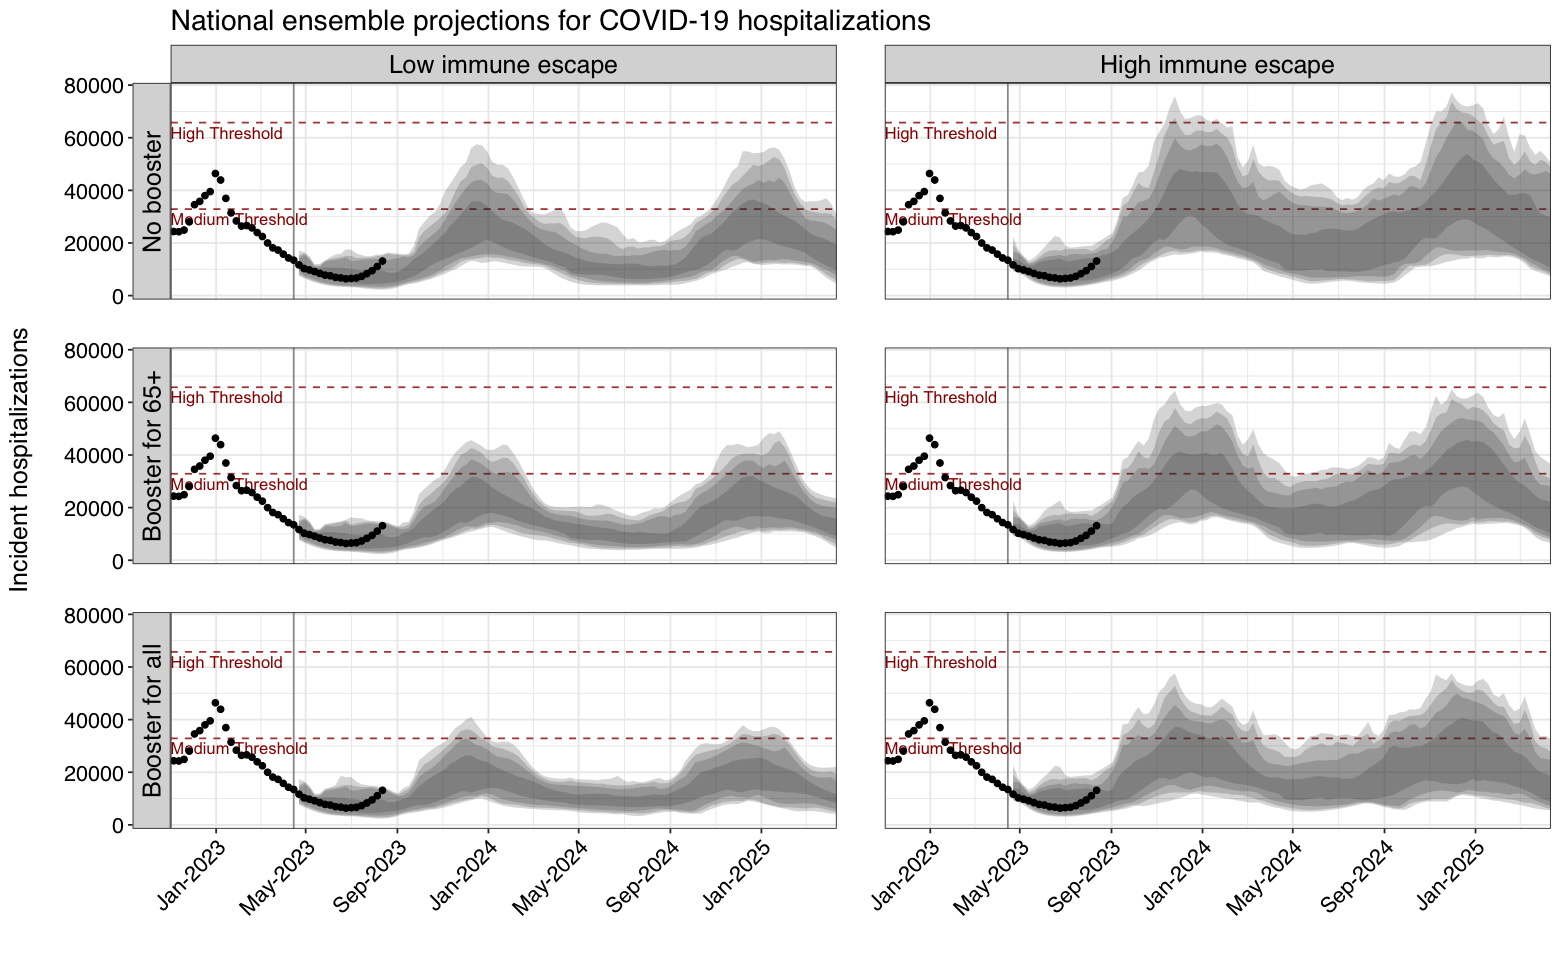

In [40]:
targets <- c("Hospitalizations", "Deaths")
lev <- unique(loc$location_name) 

v_line = data.frame(x = as.numeric(as.Date(projection.start.date)),
                    y = Inf,
                    lab = paste0("Projections begin\n",projection.start.date),
                    target_type = "Hospitalizations")

#define CDC community transmission thresholds
h_line_medthr = data.frame(x = Inf,
                           y = 32872.85,
#                            lab = paste0("Medium Threshold: 32873"),
                           lab = paste0("Medium Threshold"),
                           target_type = "Hospitalizations")

h_line_highthr = data.frame(x = Inf,
                            y = 65745.69,
#                             lab = paste0("High Threshold: 65746"),
                            lab = paste0("High Threshold"),
                            target_type = "Hospitalizations")
temp <- x %>%
filter(model == "Ensemble", type == "quantile", str_detect(target, "inc"), 
       abbreviation == "US", target_type == "Hospitalizations") %>%
pivot_wider(names_from = quantile, names_prefix = "q")
  
temp_thresholds <- filter(rbind(h_line_medthr,h_line_highthr), target_type == "Hospitalizations")
temp_mod_lab <- filter(h_line_medthr, target_type == "Hospitalizations")
temp_high_lab <- filter(h_line_highthr, target_type == "Hospitalizations")
breaks <- seq(as.Date("2020-01-01"), as.Date(projection.end.date), "4 month")

options(repr.plot.width=13,repr.plot.height=8)

temp %>%
ggplot() +
geom_vline(data = v_line %>% dplyr::select(-target_type), aes(xintercept = x), color = "grey60")+
# geom_text(data = v_line, aes(x = x, y = y, label = lab), hjust = 0, vjust = 1, size = 4)+
geom_hline(data = temp_thresholds, aes(yintercept = y), color = "#990000", linetype = 2, alpha = 0.8) +
geom_text(data = temp_thresholds, aes(x = as.Date("2022-11-01"), y = y, label = lab), 
          color = "#990000", hjust = 0, vjust = 1.3, size = 3.5) +
geom_ribbon(aes(x = target_end_date, ymin = q0.025, ymax = q0.975), alpha = 0.2) +
geom_ribbon(aes(x = target_end_date, ymin = q0.05, ymax = q0.95), alpha = 0.2) +
geom_ribbon(aes(x = target_end_date, ymin = q0.1, ymax = q0.9), alpha = 0.2) +
geom_ribbon(aes(x = target_end_date, ymin = q0.25, ymax = q0.75), alpha = 0.2) +
geom_point(data = filter(truth, location == "US", target_type == "Hospitalizations", date >= as.Date("2022-11-01")), 
           size = 1.5, aes(x = date, y = value)) +
facet_grid(cols = vars(a2), rows = vars(a1), switch = "y") +
theme_bw() +
labs(x = "", y = "Incident hospitalizations \n") +
scale_x_continuous(breaks = breaks, expand = c(0, 0), labels = format(breaks, "%b-%Y")) +
ggtitle(paste0("National ensemble projections for COVID-19 hospitalizations")) +
theme(text = element_text(size=15, family="sans",color="black"),
axis.text = element_text(size=13, family="sans",color="black"),
plot.title = element_text(size=17, family="sans",color="black"),
strip.text = element_text(size = 15, family="sans",color="black"),
axis.title.y = element_text(size=15, family="sans",color="black"),
axis.text.x = element_text(angle=45, hjust=1), 
legend.position = "none",    
panel.spacing = unit(2, "lines")) -> projection_fig
projection_fig

ggsave("Figures/Figure1.tiff", projection_fig, width=13, height=8)

In [42]:
 filter(truth, location == "US", target_type == "Hospitalizations", date >= as.Date("2022-11-01")) %>% tail()

,target,date,location_name,location,value,target_type
,<chr>,<IDate>,<chr>,<chr>,<int>,<chr>
36,hospitalization,2023-07-08,US,US,6693,Hospitalizations
37,hospitalization,2023-07-15,US,US,7308,Hospitalizations
38,hospitalization,2023-07-22,US,US,8325,Hospitalizations
39,hospitalization,2023-07-29,US,US,9463,Hospitalizations
40,hospitalization,2023-08-05,US,US,11072,Hospitalizations
41,hospitalization,2023-08-12,US,US,13132,Hospitalizations


In [44]:
colnames(x)

[1] "origin_date"     "scenario_id"     "location"        "target"         
 [5] "horizon"         "type"            "quantile"        "model"          
 [9] "value"           "target_end_date" "abbreviation"    "location_name"  
[13] "population"      "target_type"     "scenario_name"   "a1"             
[17] "a2"              "full_scenario"

In [47]:
unique(x$type)
unique(x$quantile)

x

[1] "quantile" "point"

[1] 0.900 0.950 0.975 0.025 0.050 0.100 0.250 0.500 0.750

origin_date,scenario_id,location,target,horizon,type,quantile,model,value,target_end_date,abbreviation,location_name,population,target_type,scenario_name,a1,a2,full_scenario
<date>,<chr>,<chr>,<chr>,<dbl>,<chr>,<dbl>,<fct>,<dbl>,<date>,<fct>,<fct>,<dbl>,<chr>,<chr>,<fct>,<fct>,<chr>
2023-04-16,A-2023-04-16,04,cum hosp,83,quantile,0.900,Ensemble,45524.43,2024-11-16,AZ,Arizona,7278717,Hospitalizations,noBoo_lowIE,No booster,Low immune escape,"No booster, Low immune escape"
2023-04-16,A-2023-04-16,04,cum hosp,83,quantile,0.950,Ensemble,52801.59,2024-11-16,AZ,Arizona,7278717,Hospitalizations,noBoo_lowIE,No booster,Low immune escape,"No booster, Low immune escape"
2023-04-16,A-2023-04-16,04,cum hosp,83,quantile,0.975,Ensemble,53008.32,2024-11-16,AZ,Arizona,7278717,Hospitalizations,noBoo_lowIE,No booster,Low immune escape,"No booster, Low immune escape"
2023-04-16,A-2023-04-16,04,cum hosp,84,quantile,0.025,Ensemble,16128.21,2024-11-23,AZ,Arizona,7278717,Hospitalizations,noBoo_lowIE,No booster,Low immune escape,"No booster, Low immune escape"
2023-04-16,A-2023-04-16,04,cum hosp,84,quantile,0.050,Ensemble,18015.60,2024-11-23,AZ,Arizona,7278717,Hospitalizations,noBoo_lowIE,No booster,Low immune escape,"No booster, Low immune escape"
2023-04-16,A-2023-04-16,04,cum hosp,84,quantile,0.100,Ensemble,19811.09,2024-11-23,AZ,Arizona,7278717,Hospitalizations,noBoo_lowIE,No booster,Low immune escape,"No booster, Low immune escape"
2023-04-16,A-2023-04-16,04,cum hosp,84,quantile,0.250,Ensemble,25272.37,2024-11-23,AZ,Arizona,7278717,Hospitalizations,noBoo_lowIE,No booster,Low immune escape,"No booster, Low immune escape"
2023-04-16,A-2023-04-16,04,cum hosp,84,quantile,0.500,Ensemble,34305.01,2024-11-23,AZ,Arizona,7278717,Hospitalizations,noBoo_lowIE,No booster,Low immune escape,"No booster, Low immune escape"
2023-04-16,A-2023-04-16,04,cum hosp,84,quantile,0.750,Ensemble,41364.19,2024-11-23,AZ,Arizona,7278717,Hospitalizations,noBoo_lowIE,No booster,Low immune escape,"No booster, Low immune escape"


In [41]:
temp <- x %>%
filter(model == "Ensemble", type == "quantile", str_detect(target, "inc"), abbreviation == "US", target_type == "Hospitalizations") %>%
pivot_wider(names_from = quantile, names_prefix = "q") %>%
filter(target_end_date <= as.Date("2024-04-14")) %>% 
mutate(cum_med=cumsum(q0.5), cum_lb=cumsum(q0.025), cum_up=cumsum(q0.975))

temp %>% group_by(scenario_id) %>%
slice(which.max(cum_med)) %>% ungroup() %>% 
dplyr::select(scenario_id, scenario_name, cum_med, cum_lb, cum_up)

scenario_id,scenario_name,cum_med,cum_lb,cum_up
<chr>,<chr>,<dbl>,<dbl>,<dbl>
A-2023-04-16,noBoo_lowIE,1757098,883684.1,3734295
B-2023-04-16,noBoo_highIE,1004680,503992.9,2196102
C-2023-04-16,65Boo_lowIE,3391113,1698019.4,7051278
D-2023-04-16,65Boo_highIE,2701573,1355285.2,5720374
E-2023-04-16,allBoo_lowIE,3996435,1989595.8,8232116
F-2023-04-16,allBoo_highIE,4866594,2366019.2,10003604


In [42]:
x_ci %>% filter(str_detect(target, "cum"), location == "US", model == "Ensemble", target_type == "Hospitalizations") %>%
filter(target_end_date <= as.Date("2024-04-14")) %>% group_by(full_scenario) %>%
slice(which.max(value)) %>% ungroup() %>% 
dplyr::select(scenario_id, full_scenario, value, lower, upper) %>%
mutate(value=round(value), lower=round(lower), upper=round(upper)) -> table1
table1

scenario_id,full_scenario,value,lower,upper
<chr>,<chr>,<dbl>,<dbl>,<dbl>
D-2023-04-16,"Booster for 65+, High immune escape",943147,679759,1951704
C-2023-04-16,"Booster for 65+, Low immune escape",767058,572184,1052834
F-2023-04-16,"Booster for all, High immune escape",835712,534417,1814596
E-2023-04-16,"Booster for all, Low immune escape",670194,402013,969229
B-2023-04-16,"No booster, High immune escape",1016619,738065,2156085
A-2023-04-16,"No booster, Low immune escape",824834,637506,1217790


In [76]:
x_ci %>% filter(str_detect(target, "cum"), location == "US", model == "Ensemble", target_type == "Hospitalizations") %>%
group_by(full_scenario) %>%
slice(which.max(value)) %>% ungroup() %>% 
dplyr::select(scenario_id, full_scenario, value, lower, upper) %>%
mutate(value=round(value), lower=round(lower), upper=round(upper)) -> table2
cbind(table2[,1:2], table2[,3:5]-table1[,3:5])

scenario_id,full_scenario,value,lower,upper
<chr>,<chr>,<dbl>,<dbl>,<dbl>
D-2023-04-16,"Booster for 65+, High immune escape",1898528,1202158,3809173
C-2023-04-16,"Booster for 65+, Low immune escape",1553944,1048065,2142363
F-2023-04-16,"Booster for all, High immune escape",1702493,1030212,3483618
E-2023-04-16,"Booster for all, Low immune escape",1323706,879278,1954606
B-2023-04-16,"No booster, High immune escape",2009589,1365270,4294325
A-2023-04-16,"No booster, Low immune escape",1702446,1190715,2615705


In [77]:
table2

scenario_id,full_scenario,value,lower,upper
<chr>,<chr>,<dbl>,<dbl>,<dbl>
D-2023-04-16,"Booster for 65+, High immune escape",1992400,1252465,3996288
C-2023-04-16,"Booster for 65+, Low immune escape",1624251,1089598,2258281
F-2023-04-16,"Booster for all, High immune escape",1784259,1076774,3664926
E-2023-04-16,"Booster for all, Low immune escape",1386742,913535,2060838
B-2023-04-16,"No booster, High immune escape",2110049,1427616,4520211
A-2023-04-16,"No booster, Low immune escape",1781015,1243708,2746705


In [ ]:
2,061,000

In [44]:
x_ci %>% filter(str_detect(target, "cum"), location == "US", model == "Ensemble", target_type == "Deaths") %>%
filter(target_end_date <= as.Date("2024-04-14")) %>% group_by(full_scenario) %>%
slice(which.max(value)) %>% ungroup() %>% 
dplyr::select(scenario_id, full_scenario, value, lower, upper) %>%
mutate(value=round(value), lower=round(lower), upper=round(upper)) -> table1
table1 %>% mutate(death=value/USpopsize*100000)

scenario_id,full_scenario,value,lower,upper,death
<chr>,<chr>,<dbl>,<dbl>,<dbl>,<dbl>
D-2023-04-16,"Booster for 65+, High immune escape",93872,50307,187115,28.55609
C-2023-04-16,"Booster for 65+, Low immune escape",70307,41533,115918,21.38756
F-2023-04-16,"Booster for all, High immune escape",81766,46562,181308,24.87342
E-2023-04-16,"Booster for all, Low immune escape",63036,34257,106232,19.17570
B-2023-04-16,"No booster, High immune escape",100460,62346,225886,30.56018
A-2023-04-16,"No booster, Low immune escape",78569,52993,131000,23.90088


In [45]:
x_ci %>% filter(str_detect(target, "cum"), location == "US", model == "Ensemble", target_type == "Deaths") %>%
group_by(full_scenario) %>%
slice(which.max(value)) %>% ungroup() %>% 
dplyr::select(scenario_id, full_scenario, value, lower, upper) %>%
mutate(value=round(value), lower=round(lower), upper=round(upper)) -> table2
cbind(table2[,1:2], table2[,3:5]-table1[,3:5]) %>% mutate(death=value/USpopsize*100000)

scenario_id,full_scenario,value,lower,upper,death
<chr>,<chr>,<dbl>,<dbl>,<dbl>,<dbl>
D-2023-04-16,"Booster for 65+, High immune escape",99368,70214,194865,30.22799
C-2023-04-16,"Booster for 65+, Low immune escape",80259,31219,111260,24.41498
F-2023-04-16,"Booster for all, High immune escape",89409,68880,186360,27.19844
E-2023-04-16,"Booster for all, Low immune escape",67160,26845,103915,20.43024
B-2023-04-16,"No booster, High immune escape",108223,75165,252959,32.92170
A-2023-04-16,"No booster, Low immune escape",85182,43670,172700,25.91257


Warning message:
“Using `size` aesthetic for lines was deprecated in ggplot2 3.4.0.
ℹ Please use `linewidth` instead.”


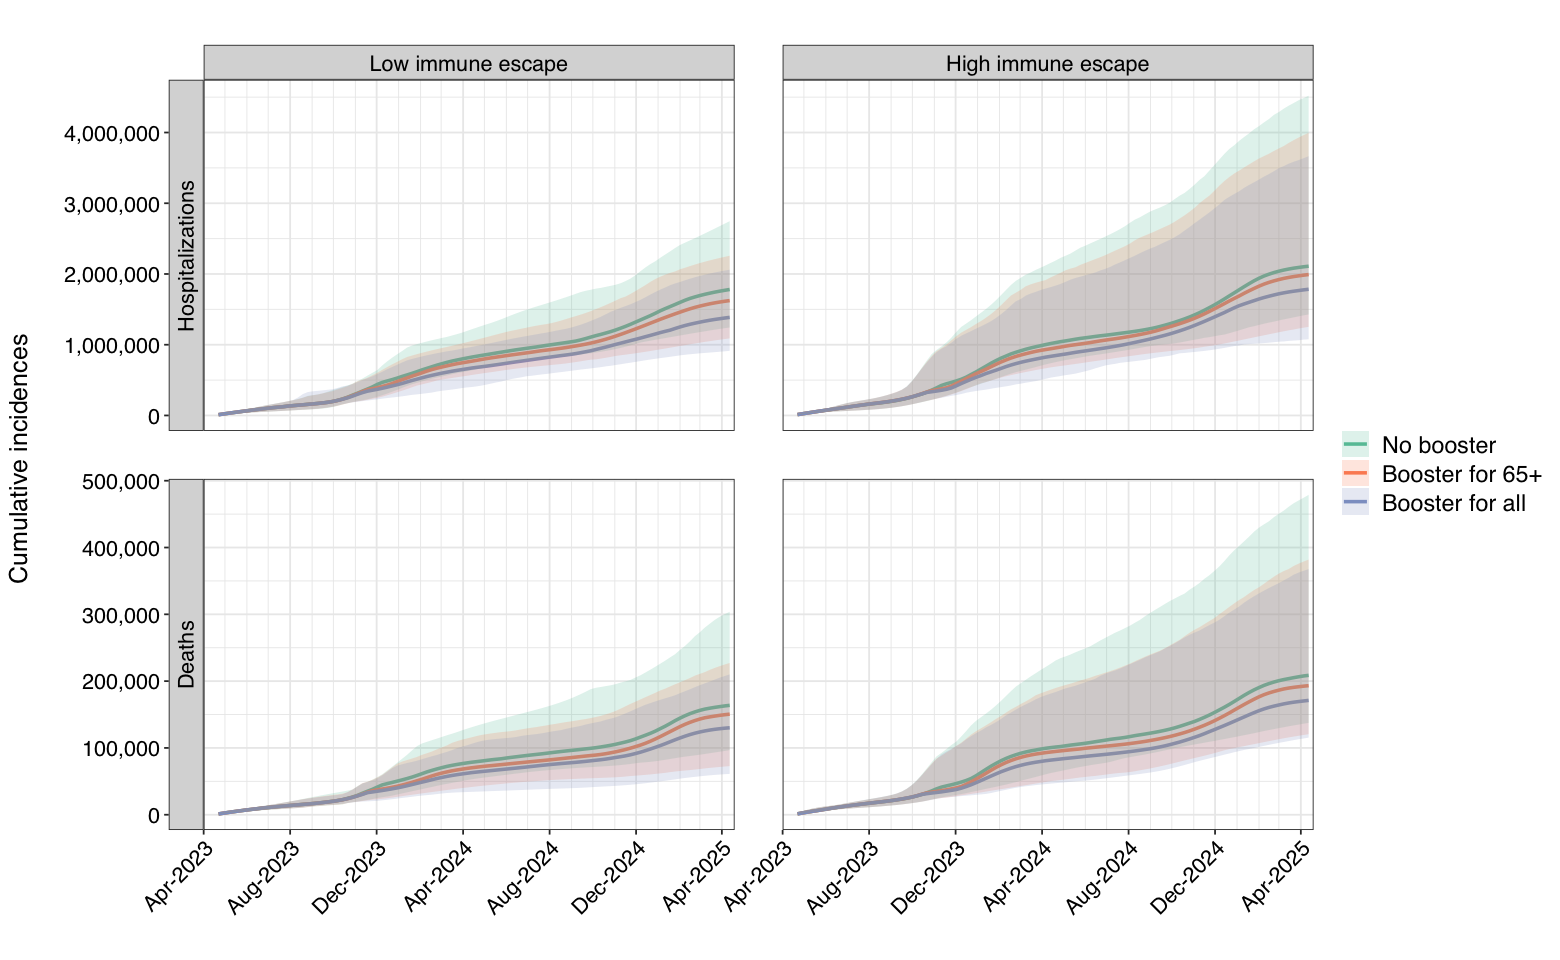

In [46]:
temp <- x_ci %>% filter(str_detect(target, "cum"), location == "US", model == "Ensemble")

options(repr.plot.width=13,repr.plot.height=8)

ggplot() +
geom_line(data = temp,  aes(x = target_end_date, y = value, color = a1), size = 1) +
geom_ribbon(data = temp, aes(x = target_end_date, ymin = lower, ymax = upper, fill = a1), alpha = 0.2) +
facet_grid(cols = vars(a2), 
         rows = vars(factor(target_type, levels = c("Hospitalizations", "Deaths"))), 
         switch = "y", scales = "free_y") +
# guides(colour = guide_legend(nrow = 1))+
scale_color_brewer("", palette = "Set2")  +
scale_fill_brewer("", palette = "Set2") +
scale_y_continuous(label=comma)+
scale_x_date(date_labels = "%b-%Y", breaks = "4 months", date_minor_breaks = "1 month",
         limits=c(as.Date("2023-04-01"), as.Date("2025-04-19")), expand = c(0, 0)) +
theme(text = element_text(size=15, family="sans",color="black"),
      axis.text = element_text(size=13, family="sans",color="black"),
      plot.title = element_text(size=17, family="sans",color="black"),
      strip.text = element_text(size = 13, family="sans",color="black"),
      axis.title.y = element_text(size=15, family="sans",color="black"),
      axis.text.x = element_text(angle=45, hjust=1), 
      legend.text = element_text(size=14),
      panel.spacing = unit(2, "lines")) +
labs(x="", y="Cumulative incidences \n", title="") -> cum_cases

cum_cases
ggsave("Figures/FigureS1.tiff", cum_cases, width=13, height=8)

# Figure 2: Prevented outcomes

In [47]:
##load the data
repo_data <- "../covid19-megaround_data/"
folder_path <- "megaround-processed/"

dc <- arrow::open_dataset(paste0(repo_data, folder_path), partitioning = "model_name", 
                          format = "parquet", schema = schema,
                          factory_options = list(
                            exclude_invalid_files = TRUE))


df_sample <- dplyr::filter(dc, type == "sample" & (target == "inc death" |  target == "inc hosp")) %>% 
  dplyr::collect()


##filter out longer time horizons
df_sample <- df_sample %>% filter(horizon<=104)

##regreate projection date
df_sample <- df_sample %>% mutate(origin_date = lubridate::as_date(origin_date))

In [48]:
res_summary <- df_sample %>%
  group_by(scenario_id, model_name, target, location, type_id)%>%
  summarize(tot=sum(value))%>%
  ungroup()%>%
  group_by(scenario_id, model_name, target, location)%>%
  summarize(scn_mn = mean(tot), scn_se=sd(tot)/sqrt(n()))%>%
  ungroup()

## within each level of immune escape.
res_summary <- res_summary %>%
  mutate(imm_escape = ifelse(scenario_id%in%c("A-2023-04-16","C-2023-04-16", "E-2023-04-16"), "Low","High"),
         vax_lvl = ifelse(scenario_id%in%c("A-2023-04-16","B-2023-04-16"), "no boost",
                          ifelse(scenario_id%in%c("C-2023-04-16","D-2023-04-16"),"65+", "all")))

res_summary %>% head()

`summarise()` has grouped output by 'scenario_id', 'model_name', 'target',
'location'. You can override using the `.groups` argument.
`summarise()` has grouped output by 'scenario_id', 'model_name', 'target'. You
can override using the `.groups` argument.


scenario_id,model_name,target,location,scn_mn,scn_se,imm_escape,vax_lvl
<chr>,<chr>,<chr>,<chr>,<dbl>,<dbl>,<chr>,<chr>
A-2023-04-16,JHU_IDD-CovidSP,inc death,01,4735.6194,157.04997,Low,no boost
A-2023-04-16,JHU_IDD-CovidSP,inc death,02,409.6049,21.19617,Low,no boost
A-2023-04-16,JHU_IDD-CovidSP,inc death,04,7653.1862,354.19585,Low,no boost
A-2023-04-16,JHU_IDD-CovidSP,inc death,05,2829.6619,114.25434,Low,no boost
A-2023-04-16,JHU_IDD-CovidSP,inc death,06,30137.3913,1466.61206,Low,no boost
A-2023-04-16,JHU_IDD-CovidSP,inc death,08,3854.8870,132.55492,Low,no boost


In [49]:
read.csv("../covid19-scenario-hub_analysis/data-locations/locations.csv") %>% 
dplyr::select(abbreviation, location, population) %>%
mutate(location=as.numeric(location)) -> df_loc

merge(res_summary %>% mutate(location=as.numeric(location)), 
      df_loc, by=c("location"), all.x=TRUE) %>% 
  filter(!(abbreviation%in%c("AS", "GU", "MP", "PR", "UM", "VI"))) %>% dplyr::select(-location) %>%
mutate(population=case_when(abbreviation==c("US")~USpopsize, TRUE~population)) -> res_summary_loc

Warning message:
“There was 1 warning in `mutate()`.
ℹ In argument: `location = as.numeric(location)`.
Caused by warning:
! NAs introduced by coercion”
Warning message:
“There was 1 warning in `mutate()`.
ℹ In argument: `location = as.numeric(location)`.
Caused by warning:
! NAs introduced by coercion”


In [50]:
##Pivot wider
res_summary_wide <- res_summary_loc %>% 
  select(-scenario_id) %>%
  pivot_wider(names_from=vax_lvl, values_from = c(scn_mn, scn_se))

In [51]:
se_ratio <- function (mn1, mn2, se1, se2) {
  mn1/mn2 * sqrt((se1/mn1)^2 + (se2/mn2)^2)
}

In [52]:
res_compares <- res_summary_wide %>%
  mutate(no_65plus_mn_diff = `scn_mn_no boost`-`scn_mn_65+`,
         no_65plus_se_diff = sqrt(`scn_se_no boost`^2+`scn_se_65+`^2),
         no_all_mn_diff = `scn_mn_no boost`-`scn_mn_all`,
         no_all_se_diff = sqrt(`scn_se_no boost`^2+`scn_se_all`^2),
         `65plus_all_mn_diff` = `scn_mn_65+`-`scn_mn_all`,
         `65plus_all_se_diff` = sqrt(`scn_se_65+`^2+`scn_se_all`^2),
         no_65plus_mn_rel = `scn_mn_65+`/`scn_mn_no boost`,
         no_65plus_se_rel = se_ratio(`scn_mn_65+`, `scn_mn_no boost`, `scn_se_65+`,`scn_se_no boost`),
         no_all_mn_rel = `scn_mn_all`/`scn_mn_no boost`,
         no_all_se_rel = se_ratio(`scn_mn_all`,`scn_mn_no boost`,  `scn_se_all`, `scn_se_no boost`),
         `65plus_all_mn_rel` = `scn_mn_all`/`scn_mn_65+`,
         `65plus_all_se_rel` = se_ratio(`scn_mn_all`,`scn_mn_65+`,`scn_se_all`, `scn_se_65+`)) %>%
  select(model_name, target, abbreviation, imm_escape,
         no_65plus_mn_diff, no_all_mn_diff,`65plus_all_mn_diff`,
         no_65plus_se_diff, no_all_se_diff,`65plus_all_se_diff`,
         no_65plus_mn_rel, no_all_mn_rel,`65plus_all_mn_rel`,
         no_65plus_se_rel, no_all_se_rel,`65plus_all_se_rel`)

In [53]:
res_compares_lng <-  res_compares %>%
  pivot_longer(cols=c(no_65plus_mn_diff,
                      no_65plus_se_diff,
                      no_all_mn_diff,
                      no_all_se_diff,
                      `65plus_all_mn_diff`,
                      `65plus_all_se_diff`,
                      no_65plus_mn_rel,
                      no_65plus_se_rel,
                      no_all_mn_rel,
                      no_all_se_rel,
                      `65plus_all_mn_rel`,
                      `65plus_all_se_rel`)) %>%
  mutate(measure=ifelse(stringr::str_detect(name,"mn"),"mn","se"),
         diff_rel = ifelse(stringr::str_detect(name,"diff"),"diff","rel"),
         compare=ifelse(stringr::str_detect(name,"no_all"), "None vs All",
                        ifelse(stringr::str_detect(name,"no_65plus"), "None vs 65+", "65+ vs All")),
         target_labs=ifelse(stringr::str_detect(target, "inc death"), "Deaths", "Hospitalizations")) %>%
  select(-name)%>%
  pivot_wider(values_from = value, names_from = measure)

In [54]:
res_compares_lng %>% filter(target==c("inc death") & abbreviation==c("WA") & diff_rel==c("rel") &
                            imm_escape==c("Low") & compare==c("None vs All")) %>% mutate(mn=1-mn) %>% arrange(mn)

model_name,target,abbreviation,imm_escape,diff_rel,compare,target_labs,mn,se
<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<dbl>,<dbl>
UNCC-hierbin,inc death,WA,Low,rel,None vs All,Deaths,0.1364275,0.006734129
USC-SIkJalpha,inc death,WA,Low,rel,None vs All,Deaths,0.1864714,0.063575173
NotreDame-FRED,inc death,WA,Low,rel,None vs All,Deaths,0.1945453,0.002425109
MOBS_NEU-GLEAM_COVID,inc death,WA,Low,rel,None vs All,Deaths,0.2779921,0.068096496
JHU_IDD-CovidSP,inc death,WA,Low,rel,None vs All,Deaths,0.3654983,0.038267610
UVA-adaptive,inc death,WA,Low,rel,None vs All,Deaths,0.4257308,0.016629951
UTA-ImmunoSEIRS,inc death,WA,Low,rel,None vs All,Deaths,0.7482300,0.016625880


In [55]:
res_compares_lng %>% filter(abbreviation=="US") -> res_compares_lng_US

In [56]:
## Gdt the random effect models for each level.
cex_val = 1
refline = 0
outcome_string  = "(Number Averted)"
tgt_vec <- c("Hospitalizations", "Deaths")
state_vec <- unique(res_compares_lng$abbreviation)

In [57]:
values <- list()
meta_res_abs <- tibble()
for(state in state_vec){
    values[[state]] <- list()
    for (imm_esc in c("Low", "High")){
      values[[state]][[imm_esc]] <- list()
      for (comparison in c("None vs 65+","None vs All","65+ vs All")) {
        values[[state]][[imm_esc]][[comparison]] <- list()
        for (tgt in tgt_vec){
          outcome_col_i <- which(tgt_vec == tgt)
          meta <- metafor::rma.uni(yi=mn, sei=se,
                                   data=filter(res_compares_lng , str_detect(target, "inc") &
                                               abbreviation==state & imm_escape==imm_esc &
                                               target_labs==tgt & compare==comparison &
                                               diff_rel=="rel" & mn > 0),
                                   control=list(stepadj=0.5, maxiter=10000))

          values[[state]][[imm_esc]][[comparison]][[tgt]] <- meta
            
          meta_res_abs <- meta_res_abs %>% bind_rows( 
              tibble(comp = comparison, imm_esc = imm_esc, target = tgt, 
                     state = state,
                     mean = as.numeric(meta[["b"]]),
                     lb = meta[["ci.lb"]],
                     ub = meta[["ci.ub"]],
                     se = meta[["se"]],
                     n_ests = length(meta[["yi"]])))
        }
      }
    }
}

merge(meta_res_abs, df_loc %>% dplyr::rename(state=abbreviation) %>% dplyr::select(state, population), 
      by=c("state"), all.x=TRUE) %>% 
mutate(imm_esc=case_when(imm_esc==c("Low")~c("Low immune escape"), 
                         imm_esc==c("High")~c("High immune escape"))) -> meta_res_rel

Warning message:
“Fisher scoring algorithm may have gotten stuck at a local maximum.
Setting tau^2 = 0. Check the profile likelihood plot with profile().”


In [58]:
values <- list()
meta_res_abs <- tibble()
for(state in state_vec){
    values[[state]] <- list()
    for (imm_esc in c("Low", "High")){
      values[[state]][[imm_esc]] <- list()
      for (comparison in c("None vs 65+","None vs All","65+ vs All")) {
        values[[state]][[imm_esc]][[comparison]] <- list()
        for (tgt in tgt_vec){
          outcome_col_i <- which(tgt_vec == tgt)
          meta <- metafor::rma.uni(yi=mn, sei=se,
                                   data=filter(res_compares_lng , str_detect(target, "inc") &
                                               abbreviation==state & imm_escape==imm_esc &
                                               target_labs==tgt & compare==comparison &
                                               diff_rel=="diff" & mn > 0),
                                   control=list(stepadj=0.5, maxiter=10000))

          values[[state]][[imm_esc]][[comparison]][[tgt]] <- meta
            
          meta_res_abs <- meta_res_abs %>% bind_rows( 
              tibble(comp = comparison, imm_esc = imm_esc, target = tgt, 
                     state = state,
                     mean = as.numeric(meta[["b"]]),
                     lb = meta[["ci.lb"]],
                     ub = meta[["ci.ub"]],
                     se = meta[["se"]],
                     n_ests = length(meta[["yi"]])))
        }
      }
    }
}

merge(meta_res_abs, df_loc %>% dplyr::rename(state=abbreviation) %>% dplyr::select(state, population), 
      by=c("state"), all.x=TRUE) %>% 
mutate(imm_esc=case_when(imm_esc==c("Low")~c("Low immune escape"), 
                         imm_esc==c("High")~c("High immune escape"))) -> meta_res_abs

In [59]:
values <- list()
meta_res_abs_national <- tibble()
for (imm_esc in c("Low", "High")){
  values[[state]][[imm_esc]] <- list()
  for (comparison in c("None vs 65+","None vs All","65+ vs All")) {
    values[[state]][[imm_esc]][[comparison]] <- list()
    for (tgt in tgt_vec){
      outcome_col_i <- which(tgt_vec == tgt)
      meta <- metafor::rma.uni(yi=mn, sei=se,
                               data=filter(res_compares_lng_US , str_detect(target, "inc") &
                                           imm_escape==imm_esc & target_labs==tgt & 
                                           compare==comparison & diff_rel=="rel"),
                               control=list(stepadj=0.5, maxiter=10000))

      values[[state]][[imm_esc]][[comparison]][[tgt]] <- meta

      meta_res_abs_national <- meta_res_abs_national %>% bind_rows( 
          tibble(comp = comparison, imm_esc = imm_esc, target = tgt, 
                 state = c("US"),
                 mean = as.numeric(meta[["b"]]),
                 lb = meta[["ci.lb"]],
                 ub = meta[["ci.ub"]],
                 se = meta[["se"]],
                 n_ests = length(meta[["yi"]])))
    }
  }
}

meta_res_abs_national %>%
mutate(imm_esc=case_when(imm_esc==c("Low")~c("Low immune escape"), 
                         imm_esc==c("High")~c("High immune escape"))) -> meta_res_rel_national

In [60]:
values <- list()
meta_res_abs_national <- tibble()
for (imm_esc in c("Low", "High")){
  values[[state]][[imm_esc]] <- list()
  for (comparison in c("None vs 65+","None vs All","65+ vs All")) {
    values[[state]][[imm_esc]][[comparison]] <- list()
    for (tgt in tgt_vec){
      outcome_col_i <- which(tgt_vec == tgt)
      meta <- metafor::rma.uni(yi=mn, sei=se,
                               data=filter(res_compares_lng_US , str_detect(target, "inc") &
                                           imm_escape==imm_esc & target_labs==tgt & 
                                           compare==comparison & diff_rel=="diff"),
                               control=list(stepadj=0.5, maxiter=10000))

      values[[state]][[imm_esc]][[comparison]][[tgt]] <- meta

      meta_res_abs_national <- meta_res_abs_national %>% bind_rows( 
          tibble(comp = comparison, imm_esc = imm_esc, target = tgt, 
                 state = c("US"),
                 mean = as.numeric(meta[["b"]]),
                 lb = meta[["ci.lb"]],
                 ub = meta[["ci.ub"]],
                 se = meta[["se"]],
                 n_ests = length(meta[["yi"]])))
    }
  }
}

meta_res_abs %>% filter(target==c("Hospitalizations") & 
                        imm_esc==c("Low Immune Escape") & comp==c("None vs All")) -> temp
meta_res_abs_national %>% mutate(population=sum(temp$population)) %>%
mutate(imm_esc=case_when(imm_esc==c("Low")~c("Low immune escape"), 
                         imm_esc==c("High")~c("High immune escape"))) %>%
mutate(value=mean/population*100000) -> meta_res_abs_national

In [61]:
rbind(meta_res_abs_national %>% filter(target==c("Hospitalizations") & imm_esc==c("High immune escape")),
      meta_res_abs_national %>% filter(target==c("Deaths") & imm_esc==c("High Immune Escape"))) 

rbind(meta_res_rel_national %>% filter(target==c("Hospitalizations") & imm_esc==c("High immune escape")),
      meta_res_rel_national %>% filter(target==c("Deaths") & imm_esc==c("Low Immune Escape"))) 

comp,imm_esc,target,state,mean,lb,ub,se,n_ests,population,value
<chr>,<chr>,<chr>,<chr>,<dbl>,<dbl>,<dbl>,<dbl>,<int>,<dbl>,<dbl>
None vs 65+,High immune escape,Hospitalizations,US,229577.8,104367.3,354788.4,63884.10,8,0,Inf
None vs All,High immune escape,Hospitalizations,US,430913.9,263930.3,597897.5,85197.27,8,0,Inf
65+ vs All,High immune escape,Hospitalizations,US,197679.4,119739.7,275619.0,39765.86,8,0,Inf


comp,imm_esc,target,state,mean,lb,ub,se,n_ests
<chr>,<chr>,<chr>,<chr>,<dbl>,<dbl>,<dbl>,<dbl>,<int>
None vs 65+,High immune escape,Hospitalizations,US,0.9152460,0.8830481,0.9474438,0.01642778,8
None vs All,High immune escape,Hospitalizations,US,0.8307502,0.7846794,0.8768211,0.02350596,8
65+ vs All,High immune escape,Hospitalizations,US,0.9087463,0.8672146,0.9502780,0.02119003,8


In [62]:
meta_res_rel_national

comp,imm_esc,target,state,mean,lb,ub,se,n_ests
<chr>,<chr>,<chr>,<chr>,<dbl>,<dbl>,<dbl>,<dbl>,<int>
None vs 65+,Low immune escape,Hospitalizations,US,0.8922916,0.8579165,0.9266668,0.01753868,8
None vs 65+,Low immune escape,Deaths,US,0.8434698,0.7746714,0.9122681,0.03510184,7
None vs All,Low immune escape,Hospitalizations,US,0.7750079,0.7122095,0.8378064,0.03204062,8
None vs All,Low immune escape,Deaths,US,0.7412360,0.6424731,0.8399988,0.05039013,7
65+ vs All,Low immune escape,Hospitalizations,US,0.8705135,0.8210495,0.9199775,0.02523722,8
65+ vs All,Low immune escape,Deaths,US,0.8752113,0.8072613,0.9431614,0.03466901,7
None vs 65+,High immune escape,Hospitalizations,US,0.9152460,0.8830481,0.9474438,0.01642778,8
None vs 65+,High immune escape,Deaths,US,0.8745229,0.8161089,0.9329370,0.02980363,7
None vs All,High immune escape,Hospitalizations,US,0.8307502,0.7846794,0.8768211,0.02350596,8


Warning message in geom_text(aes(x = 1 - mean, label = table, group = imm_esc), :
“Ignoring unknown parameters: `height`”


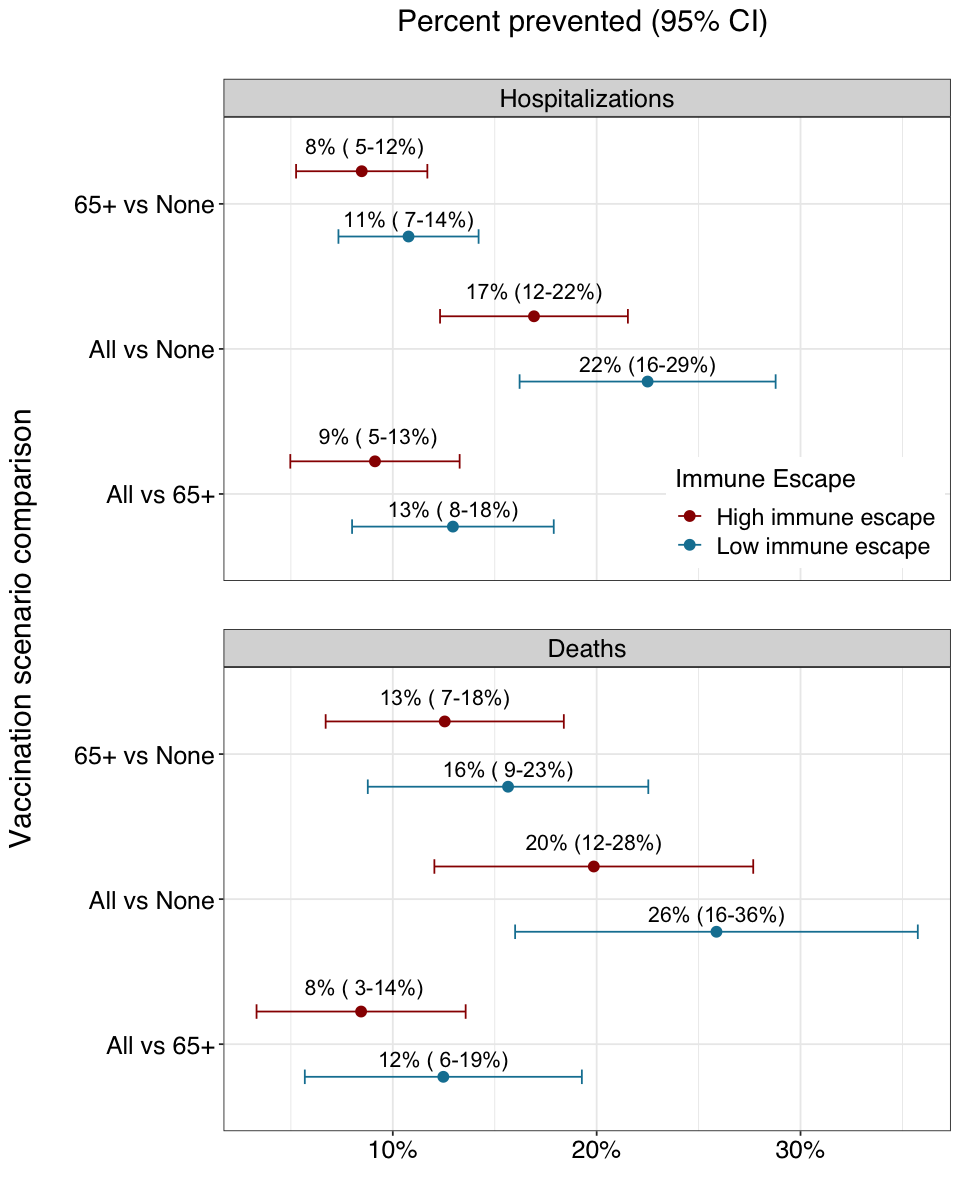

In [69]:
## figure by model
theme_set(theme_bw())
options(repr.plot.width=8,repr.plot.height=10)

meta_res_rel_national %>%
mutate(comp=case_when(comp==c("None vs All")~c("All vs None"),
                      comp==c("None vs 65+")~c("65+ vs None"), 
                      comp==c("65+ vs All")~c("All vs 65+"))) -> meta_res_rel_fig

meta_res_rel_fig$target <- factor(meta_res_rel_fig$target, levels=c("Hospitalizations", "Deaths"))
meta_res_rel_fig$comp <- factor(meta_res_rel_fig$comp, levels=c("All vs 65+",  "All vs None", "65+ vs None"))
meta_res_rel_fig$imm_esc <- factor(meta_res_rel_fig$imm_esc, levels=c("Low immune escape", "High immune escape"))

meta_res_rel_fig %>% mutate(table=paste0(format(round((1-mean)*100,0), nsmall=0),"%"," (",
                                         format(round((1-ub)*100,0), nsmall=0),"-",
                                         format(round((1-lb)*100,0), nsmall=0),"%",")")) %>%
ggplot(aes(y=comp))+
facet_wrap(~target, nrow = 2)+
geom_errorbarh(aes(xmin = 1-lb, xmax = 1-ub, group=imm_esc, color=imm_esc), 
               stat="identity", position = position_dodge(width = 0.9), height = .2) +
geom_point(aes(x = 1-mean, group=imm_esc, color=imm_esc), 
           stat="identity", position = position_dodge(width = 0.9), size = 3, pch = 16) +
geom_text(aes(x = 1-mean, label = table, group = imm_esc),
          stat="identity", position = position_dodge(width = 1), vjust = -0.9, height = .2, size = 4.5) +
scale_color_manual("Immune Escape", values=c("#1380A1", "#990000")) +
guides(color = guide_legend(reverse=TRUE)) +
theme(text = element_text(size=15, family="sans",color="black"),
      axis.text = element_text(size=15, family="sans",color="black"),
      plot.title = element_text(size=18, family="sans",color="black", hjust=0.5),
      strip.text = element_text(size = 15, family="sans",color="black"),
      axis.title.y = element_text(size = 18),
      legend.title = element_text(size=15), legend.text = element_text(size=14),
      panel.spacing = unit(2, "lines"),
      legend.position = c(0.8, 0.61),
      legend.background = element_rect(fill = "white", colour = NA)) +
scale_x_continuous(breaks=c(0, .1, .2, .3, .4), labels=c("0%", "10%", "20%", "30%", "40%"))+
labs(y="Vaccination scenario comparison \n", x="", title="Percent prevented (95% CI) \n") -> rel_vaccine_impact

rel_vaccine_impact
ggsave("Figures/Figure2_pre.tiff", rel_vaccine_impact, width=8, height=10)

In [70]:
convert_to_K <- function(number) {
  number_in_K <- format(round(number / 1000, 0), nsmall=0)
  return(paste0(number_in_K, ",000"))
}

In [71]:
rbind(meta_res_abs_national %>% filter(target==c("Hospitalizations") & imm_esc==c("High immune escape")),
      meta_res_abs_national %>% filter(target==c("Deaths") & imm_esc==c("High immune escape"))) %>% 
mutate(table=paste0("High: ", convert_to_K(mean)," (",convert_to_K(lb),"-",convert_to_K(ub),")")) -> abs_table_high

rbind(meta_res_abs_national %>% filter(target==c("Hospitalizations") & imm_esc==c("Low immune escape")),
      meta_res_abs_national %>% filter(target==c("Deaths") & imm_esc==c("Low immune escape"))) %>% 
mutate(table=paste0("Low: ", convert_to_K(mean)," (",convert_to_K(lb),"-",convert_to_K(ub),")")) -> abs_table_low

In [72]:
rbind(abs_table_high %>% dplyr::select(comp, imm_esc, target, table), 
      abs_table_low %>% dplyr::select(comp, imm_esc, target, table)) %>%
mutate(comp=case_when(comp==c("None vs All")~c("All vs None"),
                        comp==c("None vs 65+")~c("65+ vs None"), TRUE~comp)) -> table_total

table_total$target <- factor(table_total$target, levels=c("Hospitalizations", "Deaths"))
table_total$comp <- factor(table_total$comp, levels=c("65+ vs None", "All vs None", "65+ vs All"))
table_total$imm_esc <- factor(table_total$imm_esc, levels=c("High immune escape", "Low immune escape"))

Warning message in geom_text(aes(x = 1 - mean, label = table, group = imm_esc), :
“Ignoring unknown parameters: `height`”


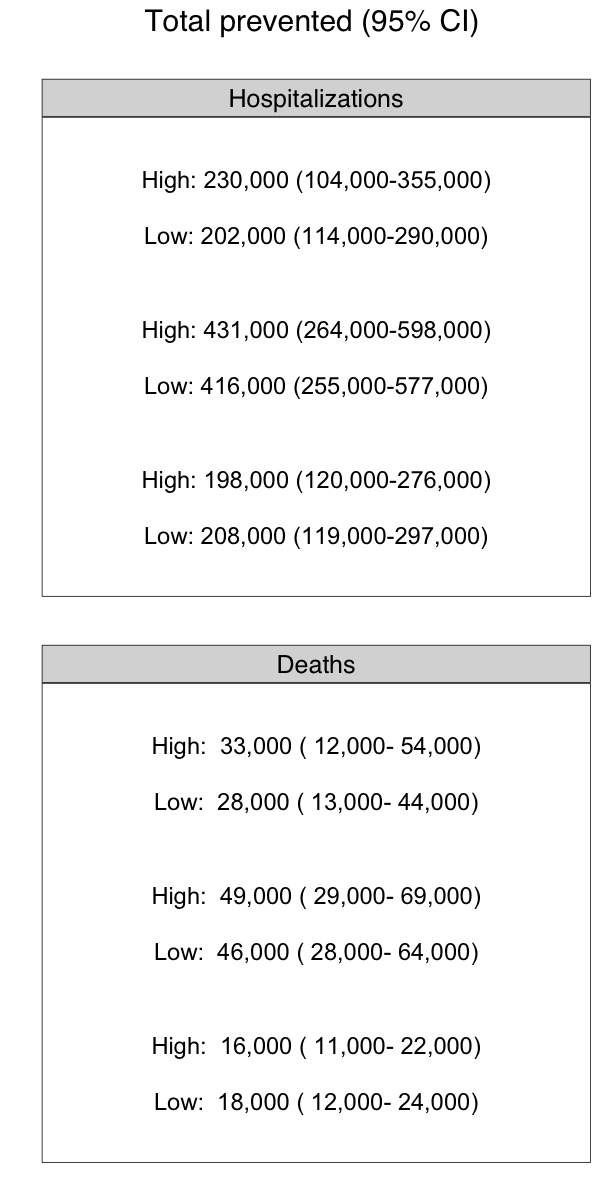

In [73]:
## figure by model
theme_set(theme_bw())
options(repr.plot.width=5,repr.plot.height=10)

rbind(abs_table_high %>% dplyr::select(comp, imm_esc, target, table), 
      abs_table_low %>% dplyr::select(comp, imm_esc, target, table)) %>%
mutate(comp=case_when(comp==c("None vs All")~c("All vs None"),
                        comp==c("None vs 65+")~c("65+ vs None"), TRUE~comp)) -> table_total

table_total$target <- factor(table_total$target, levels=c("Hospitalizations", "Deaths"))
table_total$comp <- factor(table_total$comp, levels=c("65+ vs All",  "All vs None", "65+ vs None"))
table_total$imm_esc <- factor(table_total$imm_esc, levels=c("Low immune escape", "High immune escape"))

table_total %>% mutate(mean=0.1) %>%
ggplot(aes(y=comp))+
facet_wrap(~target, nrow = 2)+
geom_point(aes(x = 1-mean, group=imm_esc, color=imm_esc), 
           stat="identity", position = position_dodge(width = 1), size = 3, pch = 16) +
geom_text(aes(x = 1-mean, label = table, group = imm_esc),
          stat="identity", position = position_dodge(width = 0.75), height = .2, size = 5) +
scale_color_manual("Immune Escape", values=c("#FFFFFF", "#FFFFFF")) +
guides(color = guide_legend(reverse=TRUE)) +
theme(text = element_text(size=15, family="sans",color="black"),
      plot.title = element_text(size=18, family="sans",color="black", hjust=0.5),
      strip.text = element_text(size = 15, family="sans",color="black"),
      legend.title = element_text(size=15), legend.text = element_text(size=14),
      panel.spacing = unit(2, "lines"),
      legend.position = 'none', 
      axis.text.x=element_blank(), axis.ticks.x=element_blank(),
      axis.text.y=element_blank(), axis.ticks.y=element_blank(), panel.grid.major=element_blank()) +
scale_x_continuous(breaks=c(0, .1, .2, .3, .4), labels=c("0%", "10%", "20%", "30%", "40%"))+
labs(y="", x="", title="Total prevented (95% CI) \n") -> rel_vaccine_impact_table

rel_vaccine_impact_table

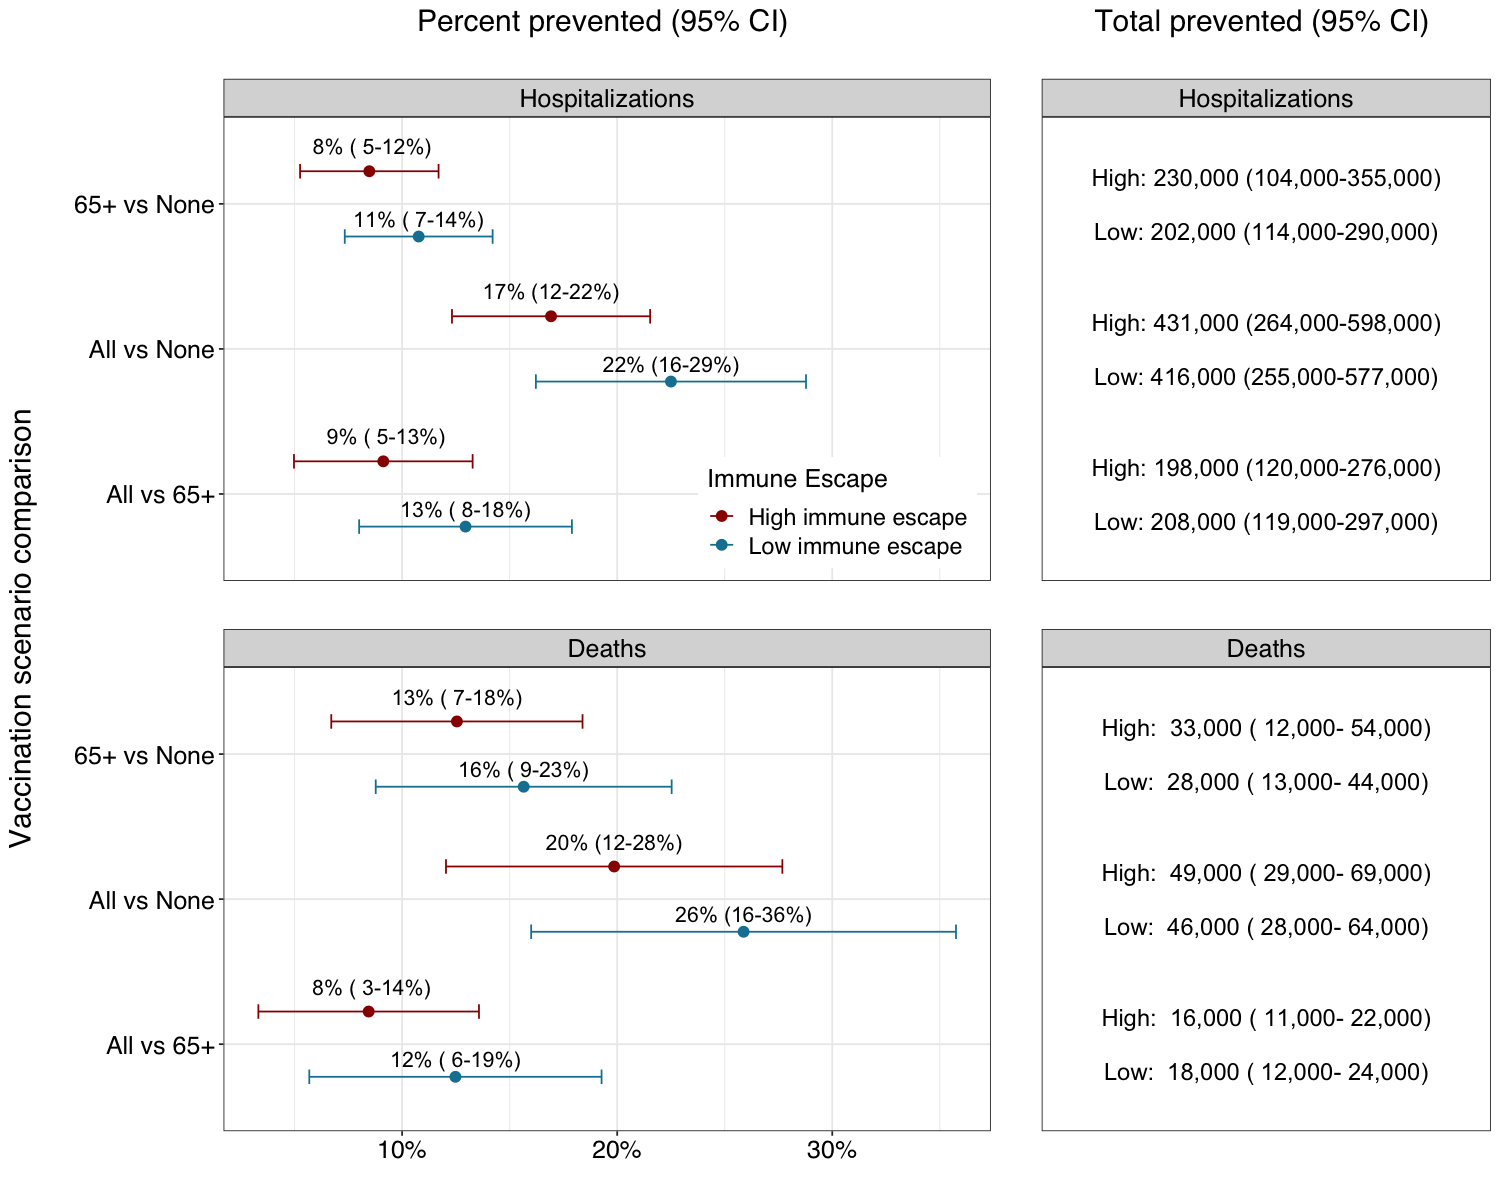

In [74]:
options(repr.plot.width=12.5,repr.plot.height=10)
cowplot::plot_grid(rel_vaccine_impact, rel_vaccine_impact_table, align = "h", nrow=1,
                   rel_widths = c(2, 1)) -> Figure2
Figure2
ggsave("Figures/Figure2.tiff", Figure2, width=12.5, height=10)

# Figure S2 & S3 : Maximum hospitalizations  & Total deaths at the state level by season

In [76]:
df_sample <- dplyr::filter(dc, type == "sample" & (target == "inc death" |  target == "inc hosp")) %>% 
  dplyr::collect()


##filter out longer time horizons
df_sample <- df_sample %>% filter(horizon<=104)

##regreate projection date
df_sample <- df_sample %>% mutate(origin_date = lubridate::as_date(origin_date))

##Create a season indicator
##First let's recreate the projection date
df_sample <- df_sample %>%
  mutate(proj_date = origin_date + horizon*7)

##week periods
date_cuts <- c("2023-04-15","2024-04-15","2025-05-01")
date_cuts<-lubridate::as_date(date_cuts)
df_sample <- df_sample %>% 
  mutate(period=cut(proj_date, date_cuts, 
                    labels = c("April 15, 2023-April 14, 2024",
                               "April 15, 2024-April 14, 2025")))

season_res <- df_sample %>% group_by(scenario_id, target,
                                     model_name,
                                     period, location,
                                     type_id) %>%
  summarize(total=sum(value), mx=max(value)) %>%
  ungroup()


##now we get the stats to plot
season_res_sum <- season_res %>%
  group_by(scenario_id, target, model_name, period, location) %>%
  summarize(tot_median = median(total),
            tot_q975=quantile(total,0.975),
            tot_q75=quantile(total,0.75),
            tot_q25=quantile(total,0.25),
            tot_q025=quantile(total,0.025),
            mx_median = median(mx),
            mx_q975=quantile(mx,0.975),
            mx_q75=quantile(mx,0.75),
            mx_q25=quantile(mx,0.25),
            mx_q025=quantile(mx,0.025))%>%
  ungroup()

##add in overall
seas_res_overall <- season_res %>%
  group_by(scenario_id, target, period, location) %>%
  summarize(tot_median = median(total),
            tot_q975=quantile(total,0.975),
            tot_q75=quantile(total,0.75),
            tot_q25=quantile(total,0.25),
            tot_q025=quantile(total,0.025),
            mx_median = median(mx),
            mx_q975=quantile(mx,0.975),
            mx_q75=quantile(mx,0.75),
            mx_q25=quantile(mx,0.25),
            mx_q025=quantile(mx,0.025))%>%
  ungroup() %>%
  mutate(model_name="Ensemble")

season_res_sum <- bind_rows(season_res_sum, seas_res_overall)

#### Summarize in a tabular format
season_res_sum$model_name <- factor(season_res_sum$model_name,
                                    levels=c("UVA-adaptive", "UVA-EpiHiper", "UTA-ImmunoSEIRS", "USC-SIkJalpha", 
                                             "UNCC-hierbin", "NotreDame-FRED", "MOBS_NEU-GLEAM_COVID", "JHU_IDD-CovidSP", "Ensemble"))

`summarise()` has grouped output by 'scenario_id', 'target', 'model_name',
'period', 'location'. You can override using the `.groups` argument.
`summarise()` has grouped output by 'scenario_id', 'target', 'model_name',
'period'. You can override using the `.groups` argument.
`summarise()` has grouped output by 'scenario_id', 'target', 'period'. You can
override using the `.groups` argument.


In [77]:
read.csv("../covid19-scenario-hub_analysis/data-locations/locations.csv") %>% 
dplyr::select(abbreviation, location, population) %>%
filter(location!="US") %>% mutate(location=as.numeric(location)) -> df_loc
merge(season_res_sum %>% filter(location!="US") %>% mutate(location=as.numeric(location)), 
      df_loc, by=c("location"), all.x=TRUE) %>% 
  filter(!(abbreviation%in%c("AS", "GU", "MP", "PR", "UM", "VI"))) -> season_res_sum_loc

In [78]:
options(repr.plot.width=10,repr.plot.height=20)

## total deaths
season_dths_tot_plt_highI_state <- season_res_sum_loc%>%
  filter(target=="inc death", model_name=="Ensemble", scenario_id%in%c("B-2023-04-16","D-2023-04-16", "F-2023-04-16"))%>%
  mutate(scenario_id=recode(scenario_id, "B-2023-04-16" = "No booster \n High immune escape",
                            "D-2023-04-16"="Booster for 65+ \n High immune escape", 
                            "F-2023-04-16"="Booster for all \n High immune escape")) %>%
  mutate(rate=tot_median/population*100000) %>%
  ggplot(aes(x=reorder(abbreviation, rate), fill=rate))+
  scale_fill_viridis_c(option = "turbo") +
  facet_grid(rows=vars(scenario_id), cols=vars(period))+
  geom_boxplot(aes(ymin=tot_q025/population*100000, lower=tot_q25/population*100000, 
                   middle=tot_median/population*100000, upper=tot_q75/population*100000, 
                   ymax=tot_q975/population*100000), stat="identity", width=0.75) + 
  scale_y_sqrt()+
  coord_flip()+
theme(legend.position="none",
      text = element_text(size=15, family="sans",color="black"),
      axis.text = element_text(size=11, family="sans",color="black"),
      plot.title = element_text(size=17, family="sans",color="black"),
      strip.text = element_text(size = 13, family="sans",color="black"),
      axis.title.y = element_text(size=15, family="sans",color="black"),
      axis.text.x = element_text(angle=45, hjust=1), 
      legend.text = element_text(size=14),
      panel.spacing = unit(2, "lines")) +
  labs(x="State \n", title="Total deaths per 100,000 individuals - High immune escape")

season_dths_tot_plt_lowI_state <- season_res_sum_loc%>%
  filter(target=="inc death", model_name=="Ensemble", scenario_id%in%c("A-2023-04-16","C-2023-04-16", "E-2023-04-16"))%>%
  mutate(scenario_id=recode(scenario_id, "A-2023-04-16" = "No booster \n Low immune escape",
                            "C-2023-04-16"="Booster for 65+ \n Low immune escape",  
                            "E-2023-04-16"="Booster for all \n Low immune escape")) %>%
  mutate(rate=tot_median/population*100000) %>% 
  ggplot(aes(x=reorder(abbreviation, rate), fill=rate))+
  scale_fill_viridis_c(option = "turbo") +
  facet_grid(rows=vars(scenario_id), cols=vars(period))+
  geom_boxplot(aes(ymin=tot_q025/population*100000, lower=tot_q25/population*100000, 
                   middle=tot_median/population*100000, upper=tot_q75/population*100000, 
                   ymax=tot_q975/population*100000), stat="identity", width=0.75) + 
  scale_y_sqrt()+
  coord_flip()+
theme(legend.position="none",
      text = element_text(size=15, family="sans",color="black"),
      axis.text = element_text(size=11, family="sans",color="black"),
      plot.title = element_text(size=17, family="sans",color="black"),
      strip.text = element_text(size = 13, family="sans",color="black"),
      axis.title.y = element_text(size=15, family="sans",color="black"),
      axis.text.x = element_text(angle=45, hjust=1), 
      legend.text = element_text(size=14),
      panel.spacing = unit(2, "lines")) +
  labs(x="State \n", title="Total deaths per 100,000 individuals - Low immune escape")

ggsave("Figures/FigureS3_1.tiff", season_dths_tot_plt_highI_state, width=10, height=20)
ggsave("Figures/FigureS3_2.tiff", season_dths_tot_plt_lowI_state, width=10, height=20)

## maximum hosp 
season_hosp_mx_plt_highI_state  <- season_res_sum_loc%>%
  filter(target=="inc hosp", model_name=="Ensemble", scenario_id%in%c("B-2023-04-16","D-2023-04-16", "F-2023-04-16"))%>%
  mutate(scenario_id=recode(scenario_id, "B-2023-04-16" = "No booster \n High immune escape",
                            "D-2023-04-16"="Booster for 65+ \n High immune escape",  
                            "F-2023-04-16"="Booster for all \n High immune escape"))%>%
  mutate(rate=mx_median/population*100000) %>%
  ggplot(aes(x=reorder(abbreviation, rate), fill=rate))+
  scale_fill_viridis_c(option = "turbo") +
  facet_grid(rows=vars(scenario_id), cols=vars(period))+
  geom_boxplot(aes(ymin=mx_q025/population*100000, lower=mx_q25/population*100000,
                   middle=mx_median/population*100000, upper=mx_q75/population*100000, 
                   ymax=mx_q975/population*100000), stat="identity", width=0.75) + 
  scale_y_sqrt()+
  coord_flip()+
theme(legend.position="none",
      text = element_text(size=15, family="sans",color="black"),
      axis.text = element_text(size=11, family="sans",color="black"),
      plot.title = element_text(size=17, family="sans",color="black"),
      strip.text = element_text(size = 13, family="sans",color="black"),
      axis.title.y = element_text(size=15, family="sans",color="black"),
      axis.text.x = element_text(angle=45, hjust=1), 
      legend.text = element_text(size=14),
      panel.spacing = unit(2, "lines")) +
  labs(x="State \n", title="Peak Hospitalizations per 100,000 population in high immune escape scenarios")

season_hosp_mx_plt_lowI_state  <- season_res_sum_loc%>%
  filter(target=="inc hosp", model_name=="Ensemble", scenario_id%in%c("A-2023-04-16","C-2023-04-16", "E-2023-04-16"))%>%
  mutate(scenario_id=recode(scenario_id, "A-2023-04-16" = "No booster \n Low immune escape",
                            "C-2023-04-16"="Booster for 65+ \n Low immune escape",  
                            "E-2023-04-16"="Booster for all \n Low immune escape"))%>%
  mutate(rate=mx_median/population*100000) %>%
  ggplot(aes(x=reorder(abbreviation, rate), fill=rate))+
  scale_fill_viridis_c(option = "turbo") +
  facet_grid(rows=vars(scenario_id), cols=vars(period))+
  geom_boxplot(aes(ymin=mx_q025/population*100000, lower=mx_q25/population*100000, 
                   middle=mx_median/population*100000, upper=mx_q75/population*100000, 
                   ymax=mx_q975/population*100000), stat="identity", width=0.75) + 
  scale_y_sqrt()+
  coord_flip()+
theme(legend.position="none",
      text = element_text(size=15, family="sans",color="black"),
      axis.text = element_text(size=11, family="sans",color="black"),
      plot.title = element_text(size=17, family="sans",color="black"),
      strip.text = element_text(size = 13, family="sans",color="black"),
      axis.title.y = element_text(size=15, family="sans",color="black"),
      axis.text.x = element_text(angle=45, hjust=1), 
      legend.text = element_text(size=14),
      panel.spacing = unit(2, "lines")) +
  labs(x="State \n", title="Peak hospitalizations per 100,000 population - Low immune escape")

ggsave("Figures/FigureS2_1.tiff", season_hosp_mx_plt_highI_state , width=10, height=20)
ggsave("Figures/FigureS2_2.tiff", season_hosp_mx_plt_lowI_state , width=10, height=20)

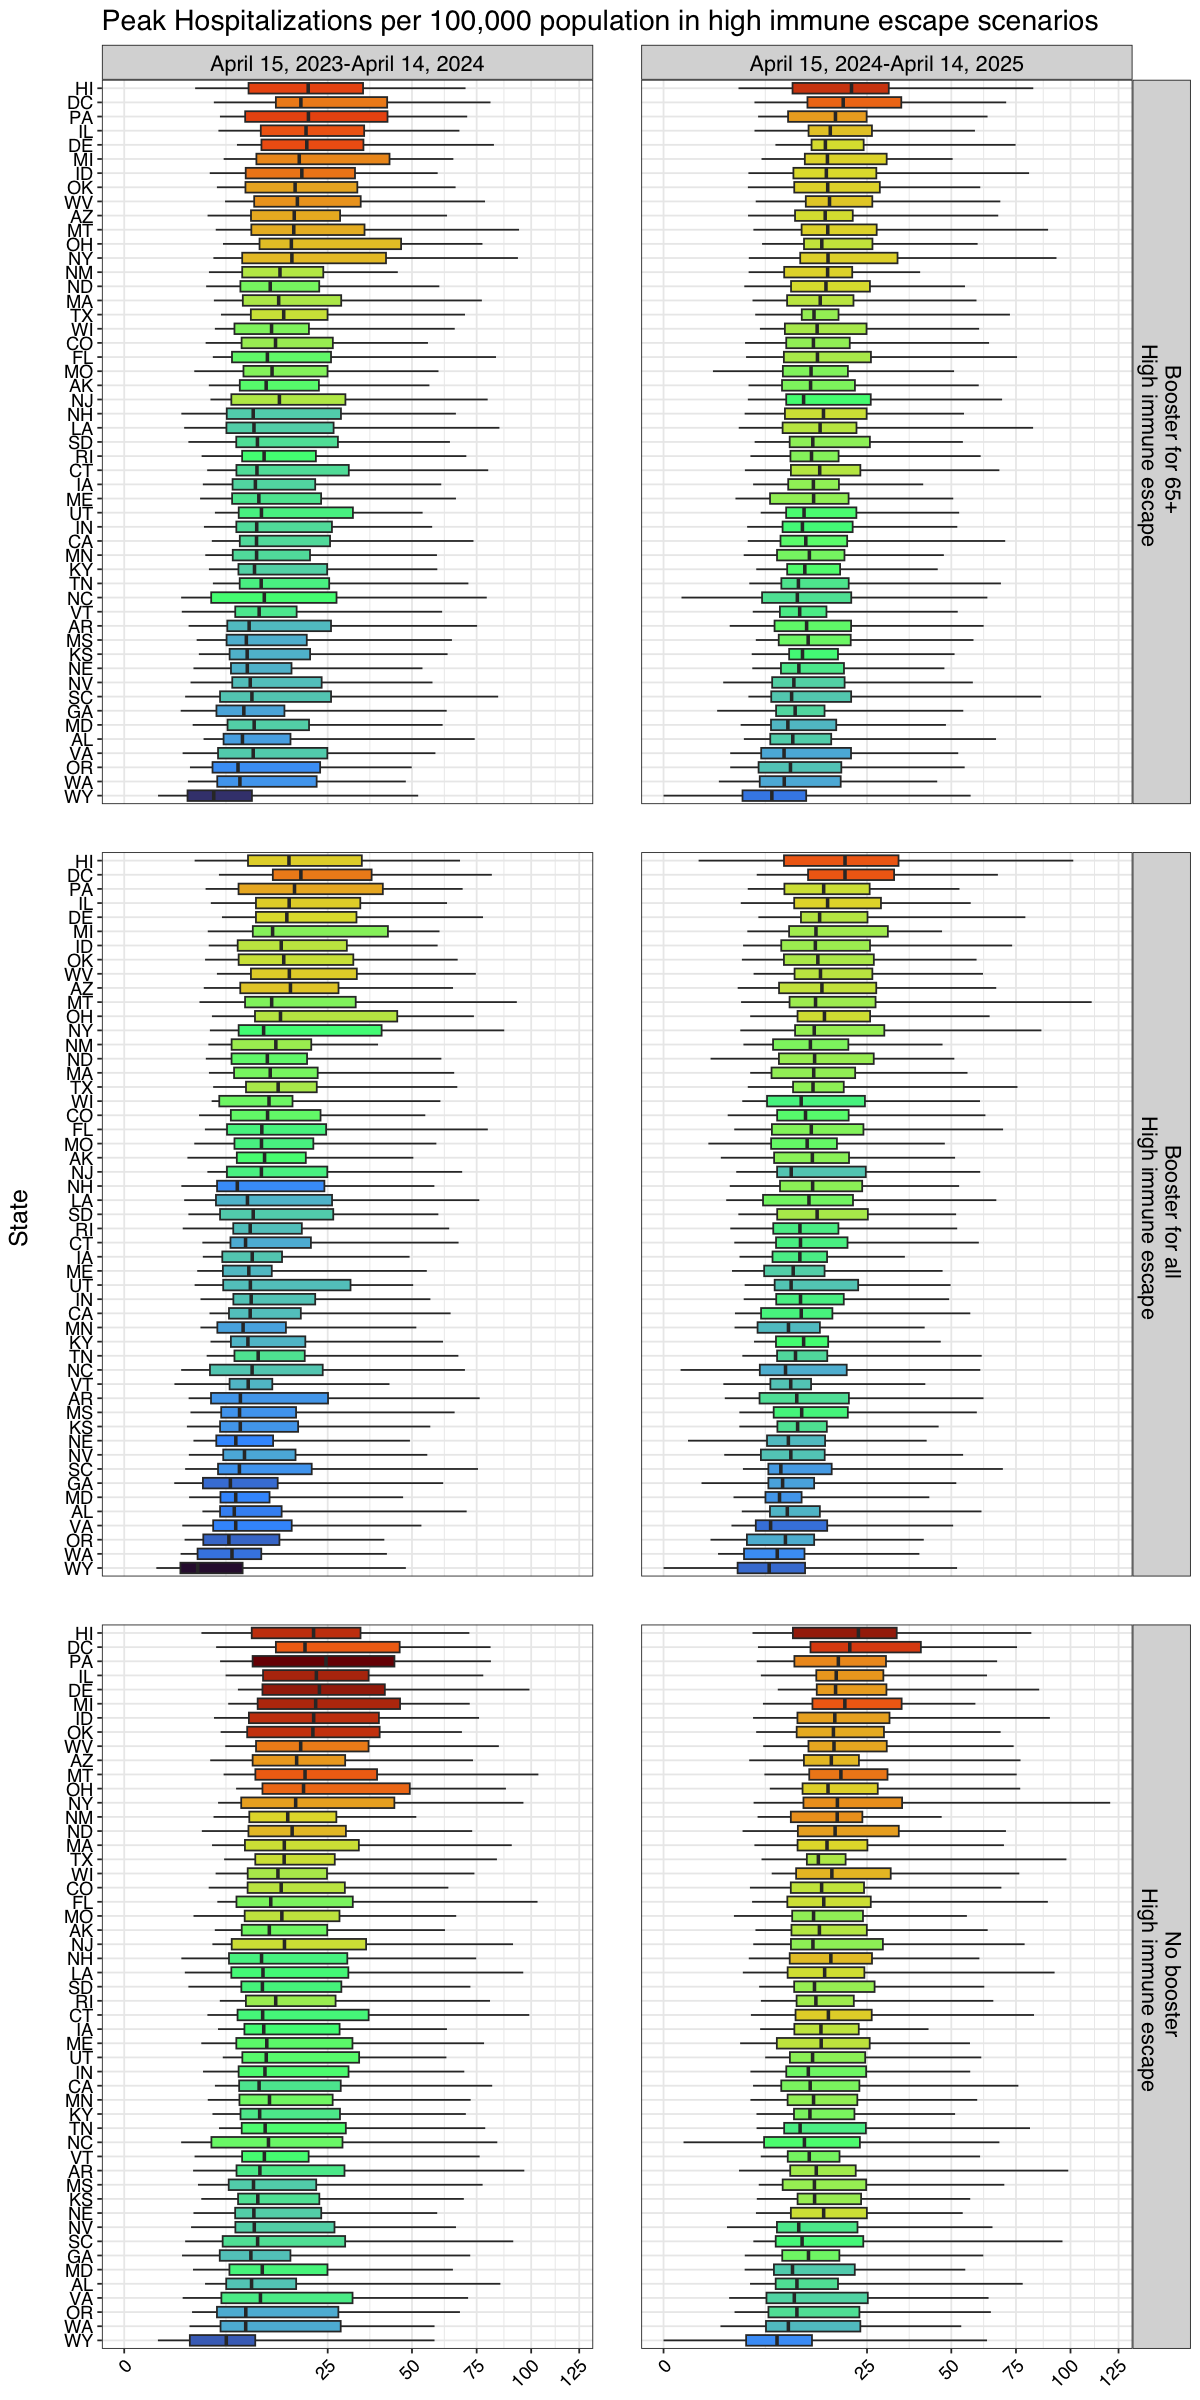

In [79]:
season_hosp_mx_plt_highI_state

In [81]:
## peak timing by state
season_hosp_mx_plt_highI_state  <- season_res_sum_loc%>%
  filter(target=="inc hosp", model_name=="Ensemble", scenario_id%in%c("B-2023-04-16","D-2023-04-16", "F-2023-04-16"))%>%
  mutate(scenario_id=recode(scenario_id, "B-2023-04-16" = "No booster \n High immune escape",
                            "D-2023-04-16"="Booster for 65+ \n High immune escape",  
                            "F-2023-04-16"="Booster for all \n High immune escape"))%>%
  mutate(rate=mx_median/population*100000) %>%
  ggplot(aes(x=reorder(abbreviation, rate), fill=rate))+
  scale_fill_viridis_c(option = "turbo") +
  facet_grid(rows=vars(scenario_id), cols=vars(period))+
  geom_boxplot(aes(ymin=mx_q025/population*100000, lower=mx_q25/population*100000,
                   middle=mx_median/population*100000, upper=mx_q75/population*100000, 
                   ymax=mx_q975/population*100000), stat="identity", width=0.75) + 
  scale_y_sqrt()+
  coord_flip()+
theme(legend.position="none",
      text = element_text(size=15, family="sans",color="black"),
      axis.text = element_text(size=11, family="sans",color="black"),
      plot.title = element_text(size=17, family="sans",color="black"),
      strip.text = element_text(size = 13, family="sans",color="black"),
      axis.title.y = element_text(size=15, family="sans",color="black"),
      axis.text.x = element_text(angle=45, hjust=1), 
      legend.text = element_text(size=14),
      panel.spacing = unit(2, "lines")) +
  labs(x="State \n", title="Max Hospitalizations per 100,000 individuals - High immune escape")

season_hosp_mx_plt_lowI_state  <- season_res_sum_loc%>%
  filter(target=="inc hosp", model_name=="Ensemble", scenario_id%in%c("A-2023-04-16","C-2023-04-16", "E-2023-04-16"))%>%
  mutate(scenario_id=recode(scenario_id, "A-2023-04-16" = "No booster \n Low immune escape",
                            "C-2023-04-16"="Booster for 65+ \n Low immune escape",  
                            "E-2023-04-16"="Booster for all \n Low immune escape"))%>%
  mutate(rate=mx_median/population*100000) %>%
  ggplot(aes(x=reorder(abbreviation, rate), fill=rate))+
  scale_fill_viridis_c(option = "turbo") +
  facet_grid(rows=vars(scenario_id), cols=vars(period))+
  geom_boxplot(aes(ymin=mx_q025/population*100000, lower=mx_q25/population*100000, 
                   middle=mx_median/population*100000, upper=mx_q75/population*100000, 
                   ymax=mx_q975/population*100000), stat="identity", width=0.75) + 
  scale_y_sqrt()+
  coord_flip()+
theme(legend.position="none",
      text = element_text(size=15, family="sans",color="black"),
      axis.text = element_text(size=11, family="sans",color="black"),
      plot.title = element_text(size=17, family="sans",color="black"),
      strip.text = element_text(size = 13, family="sans",color="black"),
      axis.title.y = element_text(size=15, family="sans",color="black"),
      axis.text.x = element_text(angle=45, hjust=1), 
      legend.text = element_text(size=14),
      panel.spacing = unit(2, "lines")) +
  labs(x="State \n", title="Max Hospitalizations per 100,000 individuals - Low immune escape")

ggsave("Figures/FigureS3_1.tiff", season_hosp_mx_plt_highI_state , width=10, height=20)
ggsave("Figures/FigureS3_2.tiff", season_hosp_mx_plt_lowI_state , width=10, height=20)

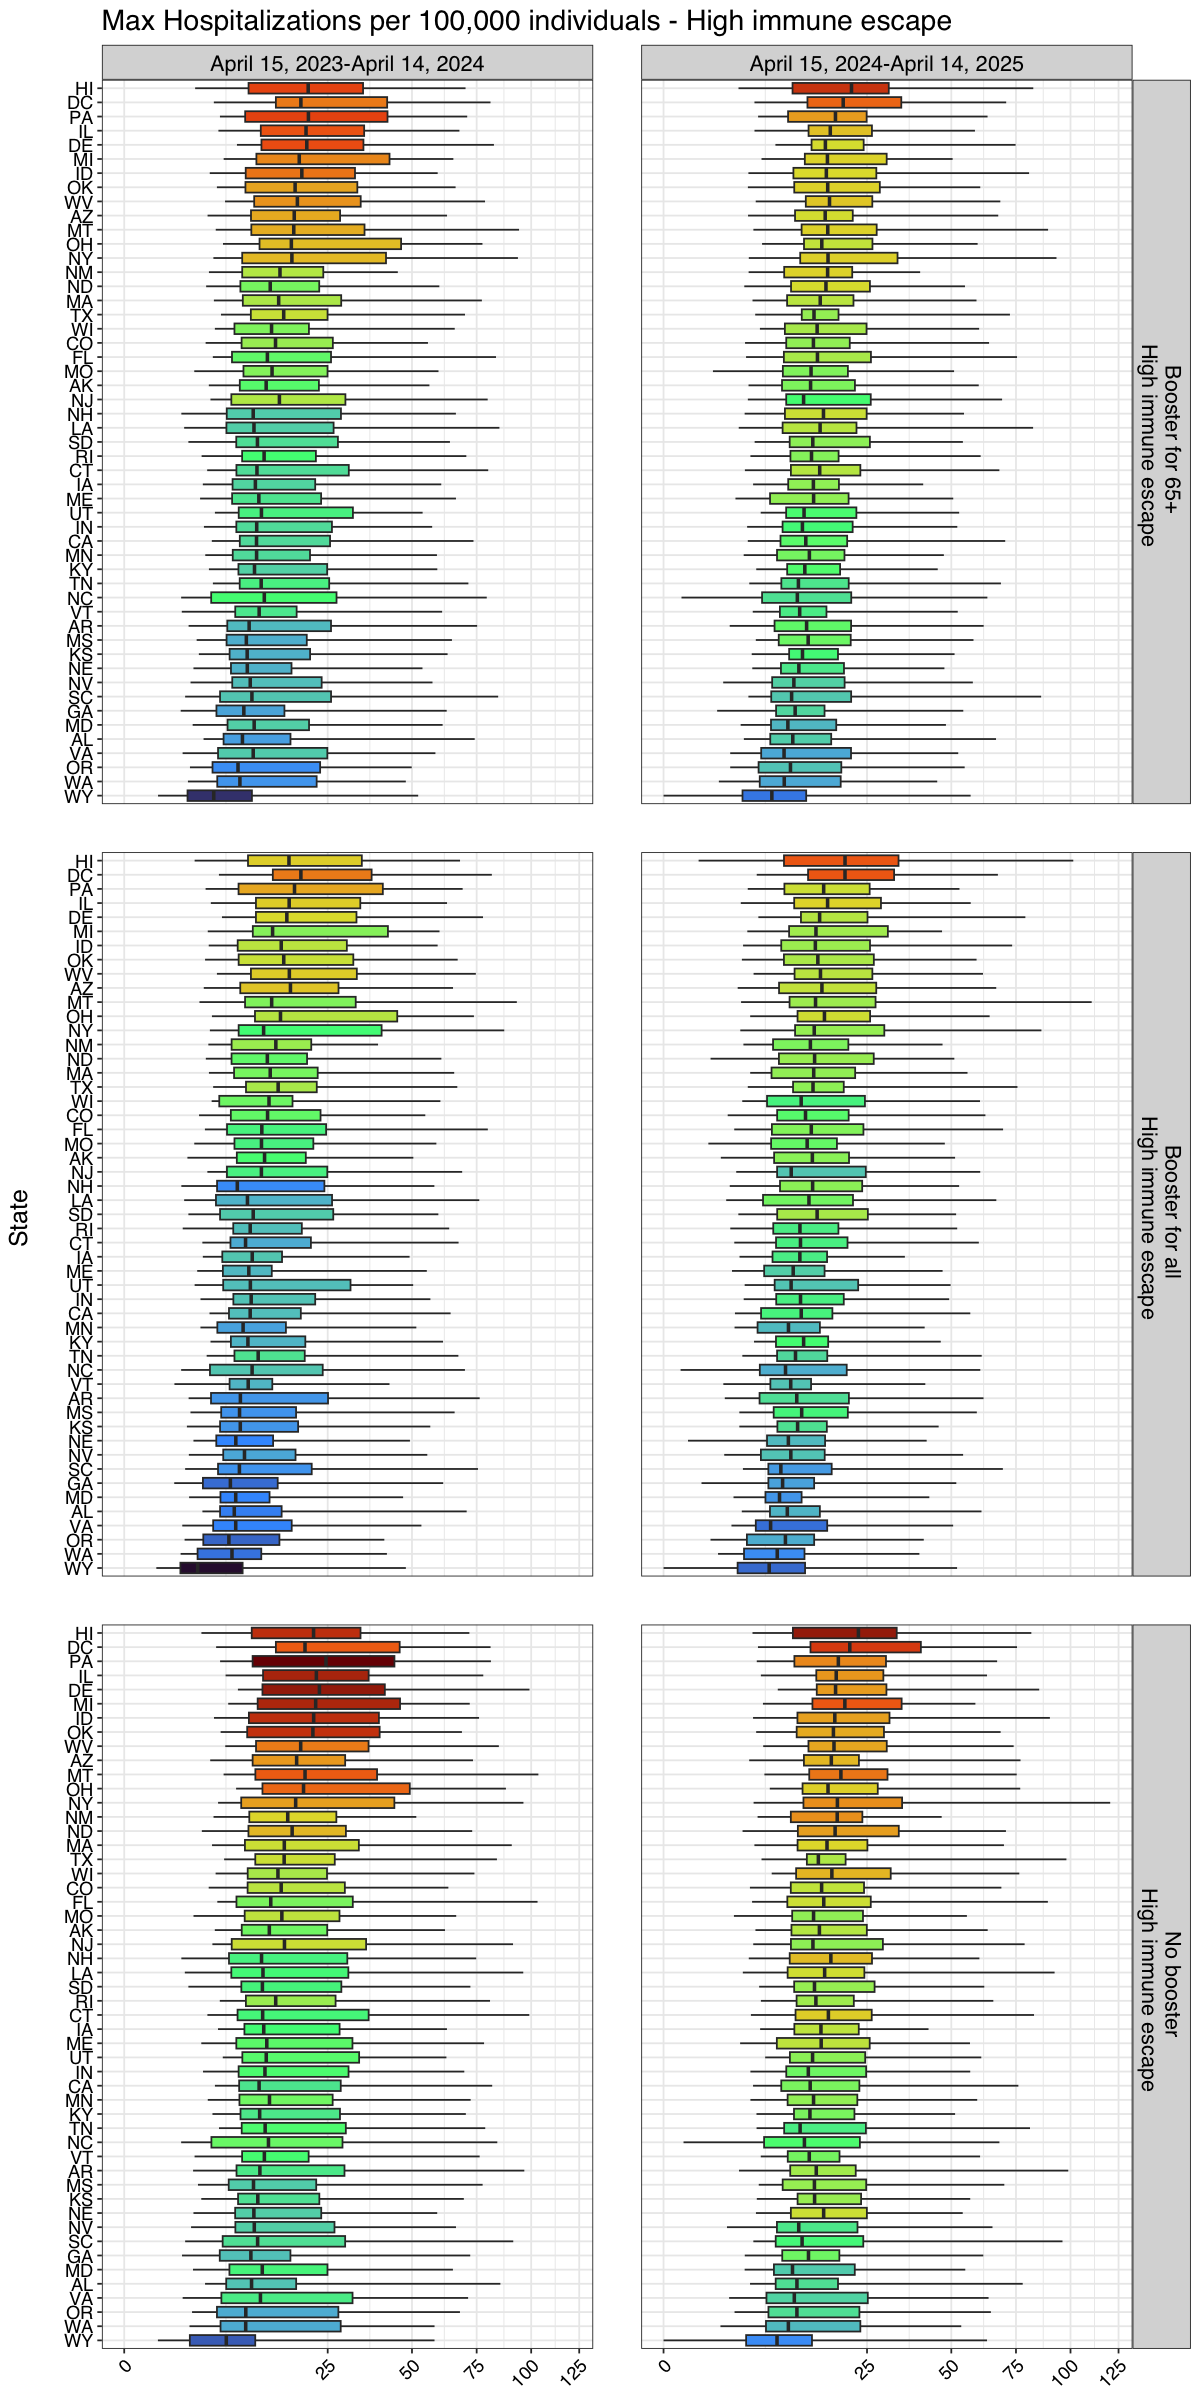

In [82]:
season_hosp_mx_plt_highI_state

In [126]:
citation(package='metafor')


To cite the metafor package in publications, please use:

  Viechtbauer, W. (2010). Conducting meta-analyses in R with the
  metafor package. Journal of Statistical Software, 36(3), 1-48.
  https://doi.org/10.18637/jss.v036.i03

A BibTeX entry for LaTeX users is

  @Article{,
    title = {Conducting meta-analyses in {R} with the {metafor} package},
    author = {Wolfgang Viechtbauer},
    journal = {Journal of Statistical Software},
    year = {2010},
    volume = {36},
    number = {3},
    pages = {1--48},
    doi = {10.18637/jss.v036.i03},
  }
